# ***Filtering Operations***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift
from scipy.signal import convolve2d

from Functions import *
from gaussfft import gaussfft
from fftwave import fftwave

# Change default figure size
plt.rcParams["figure.figsize"] = (16, 10)

## 1) Discrete Fourier Transform

### Basis functions

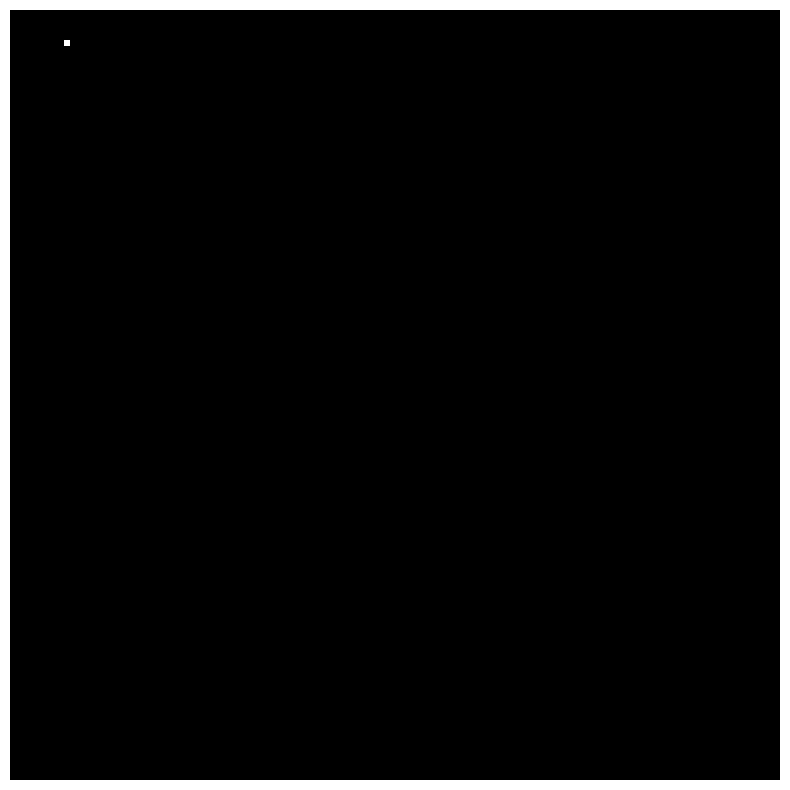

In [2]:
Fhat = np.zeros((128, 128))
Fhat[5, 9] = 1

showgrey(Fhat)

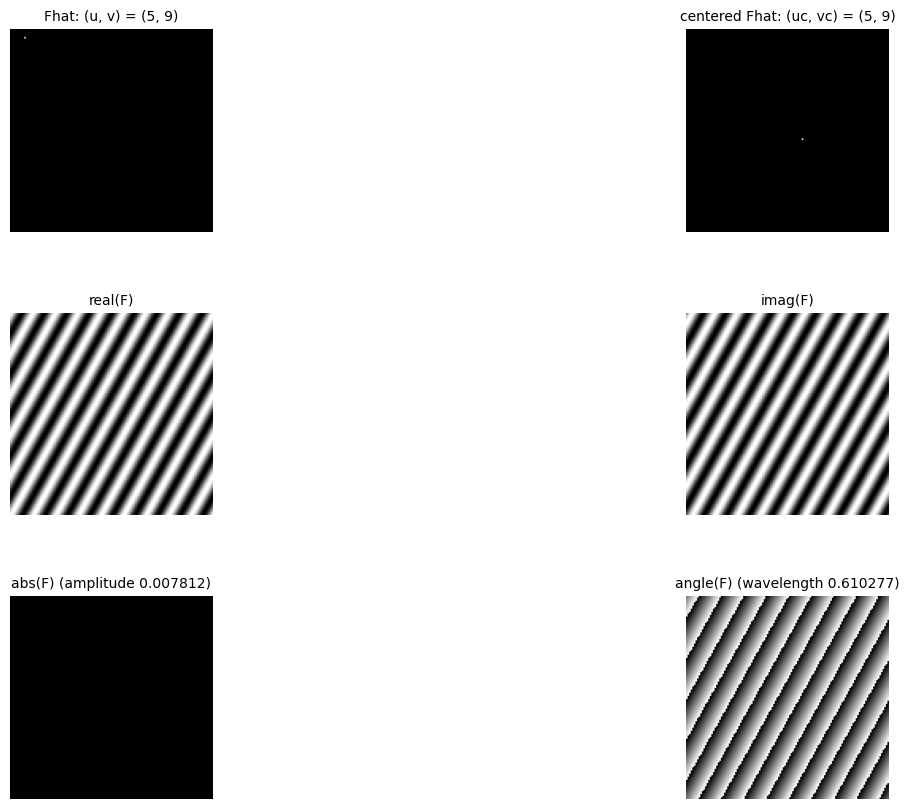

In [3]:
fftwave(5,9)

Number 1:


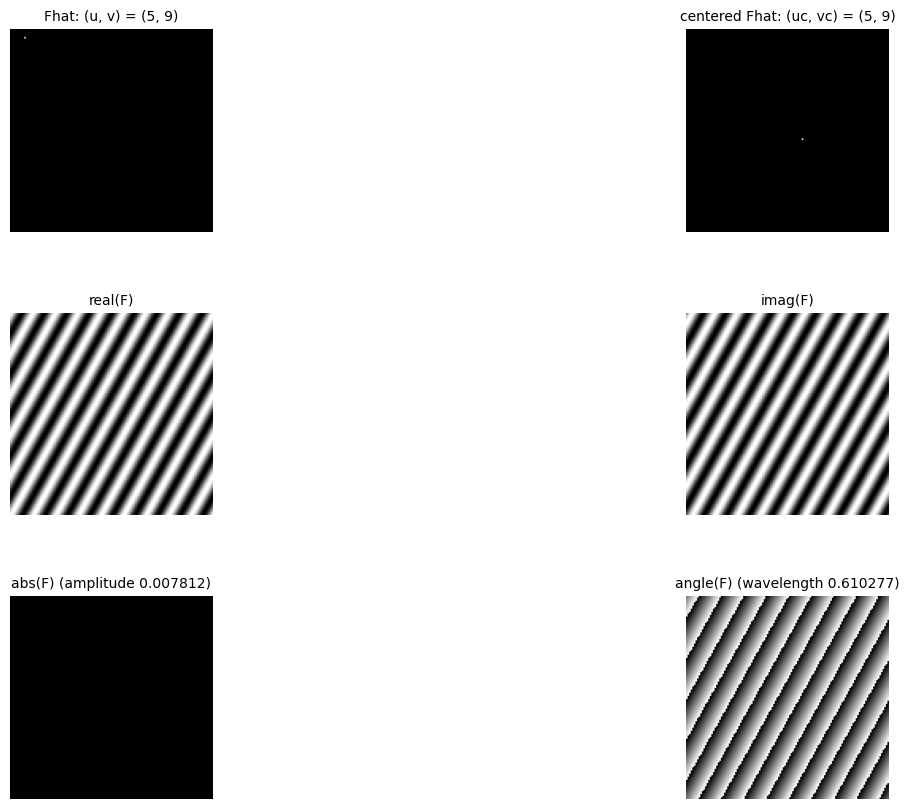

Number 2:


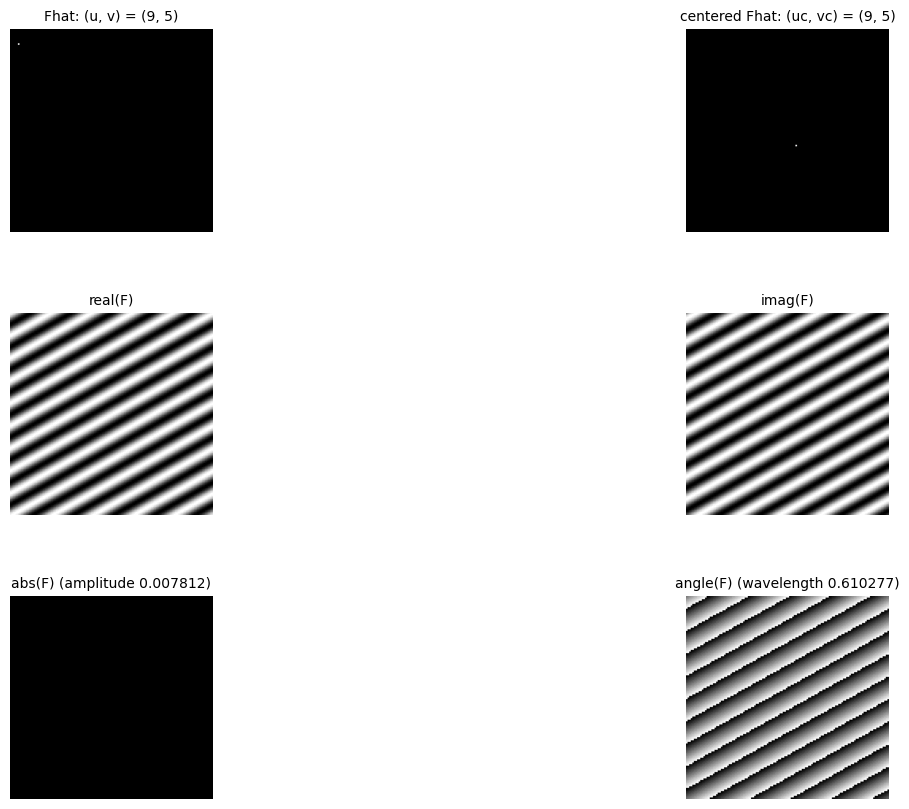

Number 3:


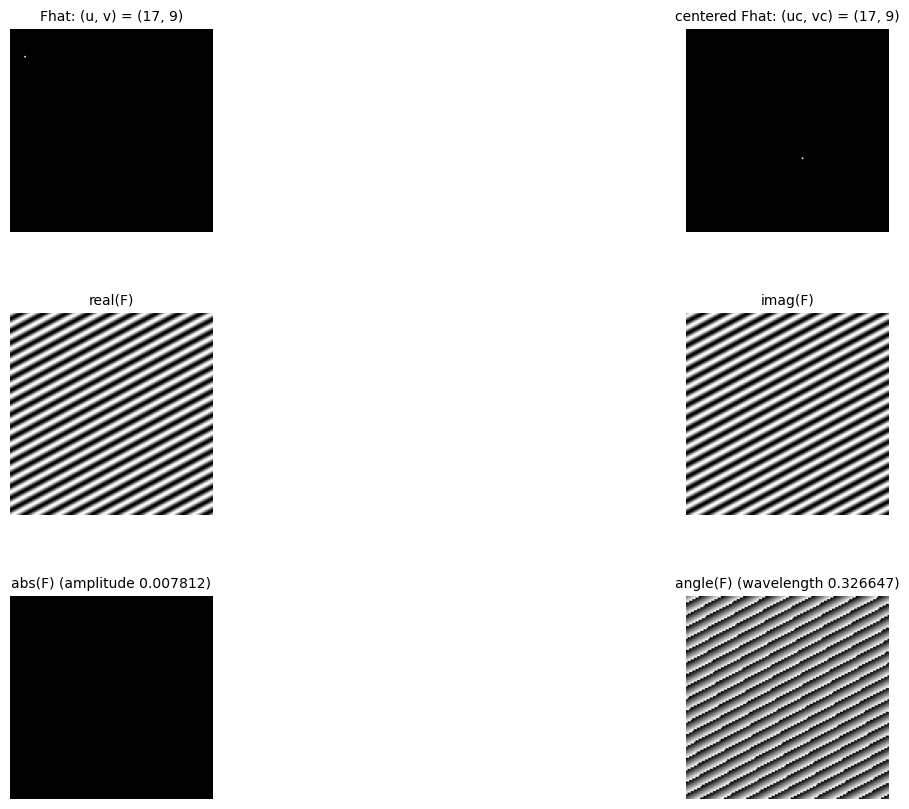

Number 4:


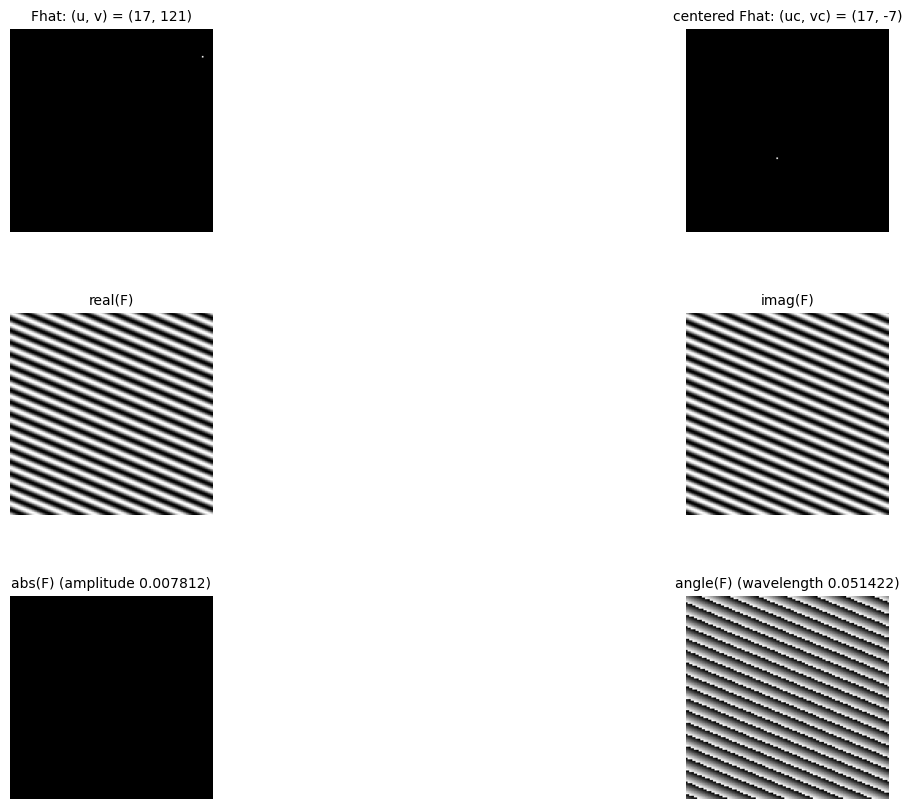

Number 5:


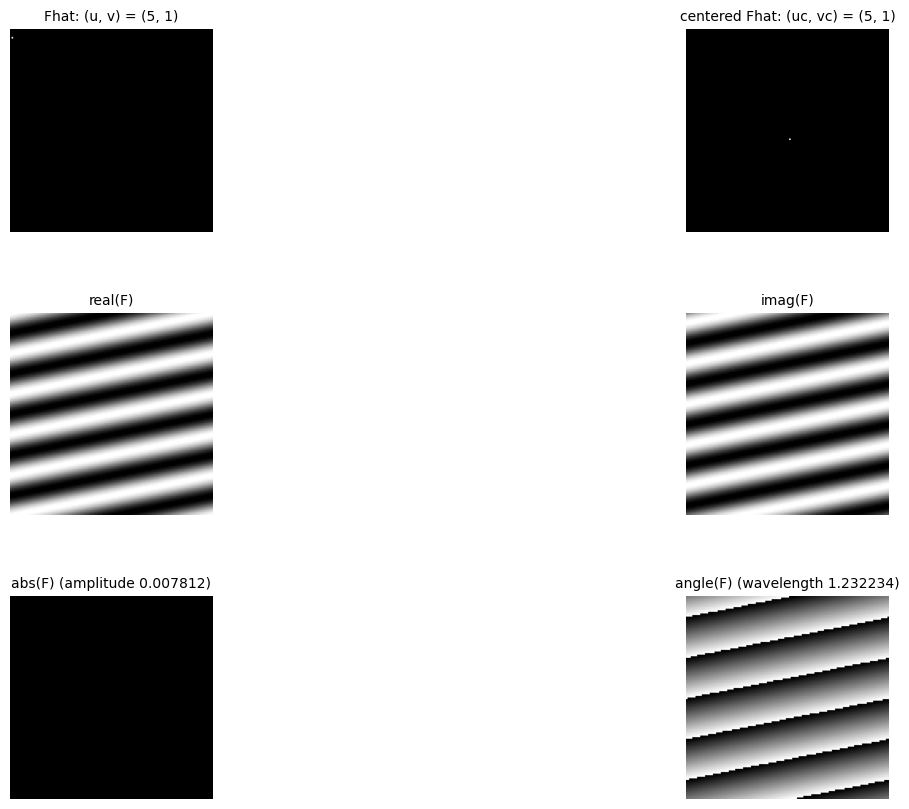

Number 6:


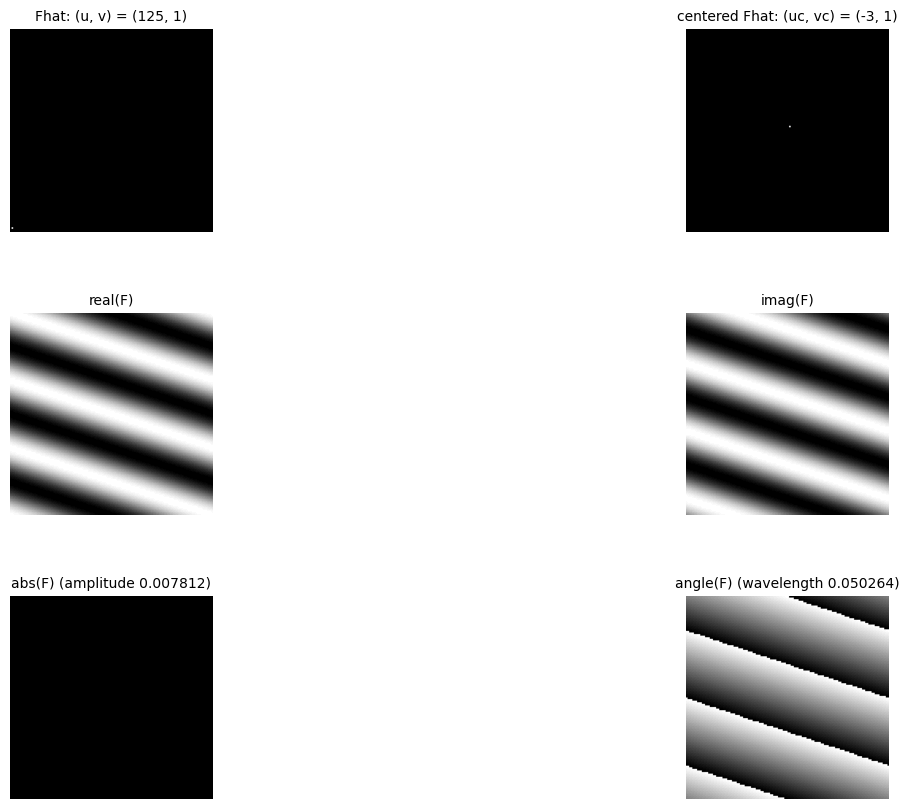

In [51]:
P = [5, 9, 17, 17, 5, 125]
Q = [9, 5, 9, 121, 1, 1]
n = 0

for p,q in zip(P,Q):
    n += 1
    print('Number {}:'.format(n))
    fftwave(p,q)

We observe that:
- distance to the origin is related to frequency
- real part seems to be delayed from the imaginary one
- orientation of the sin/cos is related to the orientation of the basis function
- amplitude is always the same

The Fourier transform decomposes a signal or image into a sum of sinusoids (sine and cosine waves), each with a different frequency, amplitude, and phase. These sinusoids can be thought of as projections of the signal in the frequency domain.

Conversely, in the Fourier domain, a point $(p, q)$ corresponds to a sine wave (or a complex exponential) in the spatial domain. The inverse Fourier transform reconstructs the signal $f(x, y)$ by summing the contributions of all frequency components. The contribution of each frequency component is given by:

$$
f(x) = \frac{1}{N} \sum_{u} F(u) e^{\frac{2\pi i u^{T} x}{N}}
$$

This complex exponential can be rewritten as a combination of sine and cosine functions, representing a pure frequency at the corresponding spatial location.

If we express the inverse Fourier transform as a sum of sine and cosine components, the equation becomes:

$$
f(x_{1}, x_{2}) = \frac{F(p, q)}{N} \left( \cos(\frac{2\pi (p x_{1} + q x_{2})}{N}) + i \sin(\frac{2\pi (p x_{1} + q x_{2})}{N}) \right)
$$

Here, $F(p,q)=1$, then:

$$
f(x_{1}, x_{2}) = \frac{1}{N} \left( \cos(\frac{2\pi (p x_{1} + q x_{2})}{N}) + i \sin(\frac{2\pi (p x_{1} + q x_{2})}{N}) \right)
$$

The amplitude is $\frac{1}{N}=0.0078725$.

The wavelength is given by: $\lambda_{D} = \frac{2\pi}{||\omega_{D}||} = \frac{N}{||u||}$

### Nyquist frequency

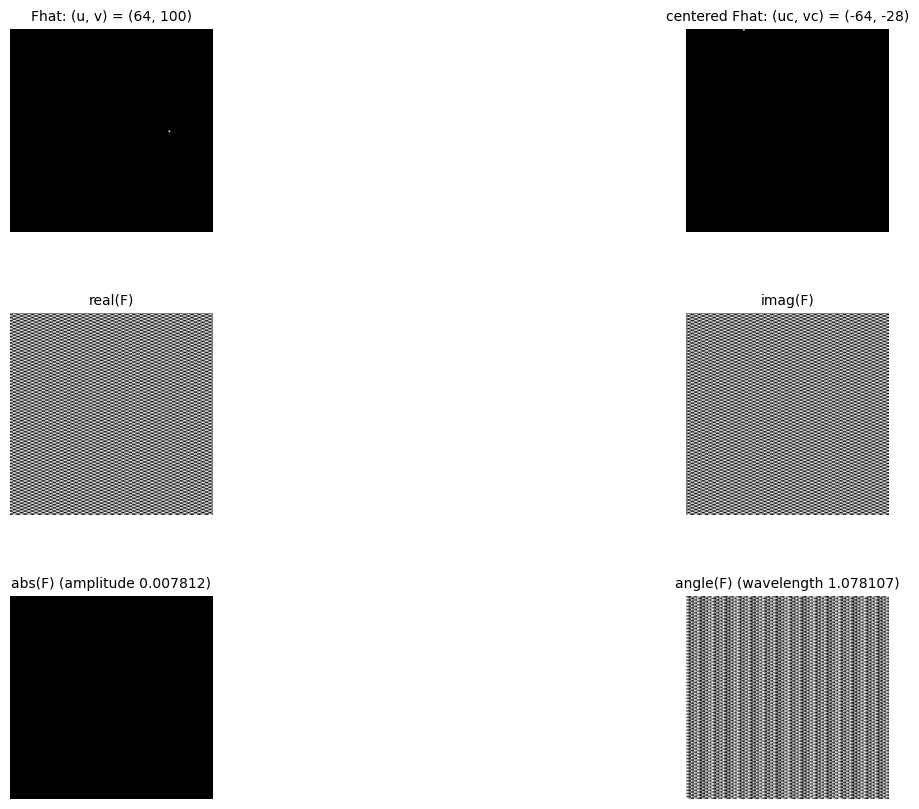

In [4]:
fftwave(64, 100)

In image processing, the sampling rate is represented by resolution (number of pixels). Shannon's theorem tells us how to choose it to capture a given image. However, we are often limited by computational resources. Therefore, we have to use anti aliasing filters, blurring the image to remove the highest frequencies (the ones above nyquist frequency).

The Nyquist frequency, $\frac{f_s}{2}$, represents the highest frequency that can be accurately represented at a given sampling rate $f_s$ (derives from Shannon's theorem).
When the Fourier spectrum contains frequencies above the Nyquist frequency (which is reached in the point in center), these components “fold” back into the lower frequency range, effectively mapping high frequencies to incorrect, lower frequencies (for example, if you have a frequency component at 1.5 times the Nyquist frequency, it will appear in the inverse transform as a frequency at half the Nyquist frequency).

In practice, we only compute FT for a quarter of the frequency map in 2D, thanks to the symmetry of the FT.

### Linearity

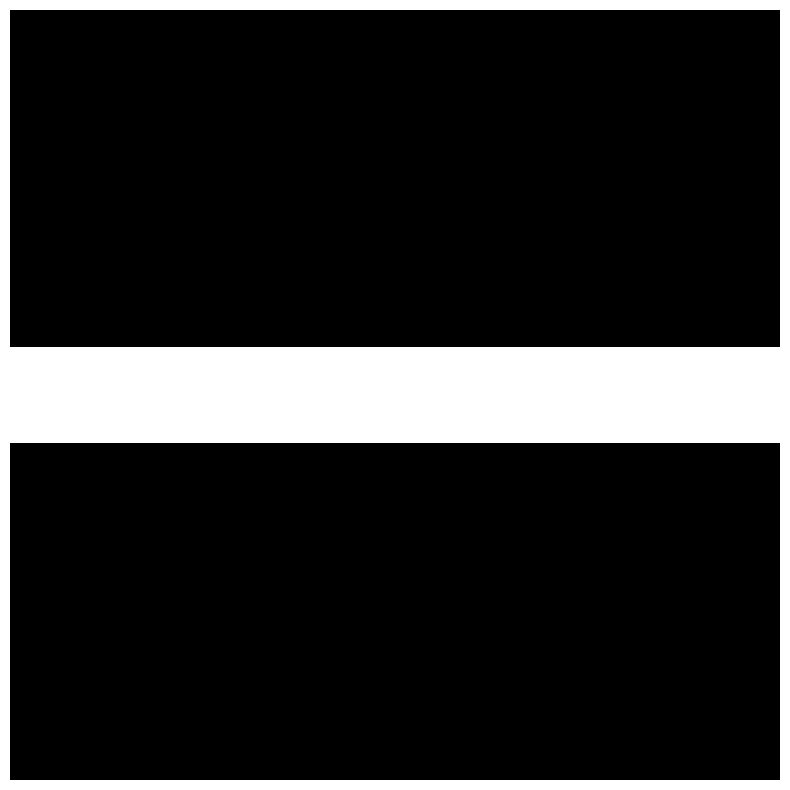

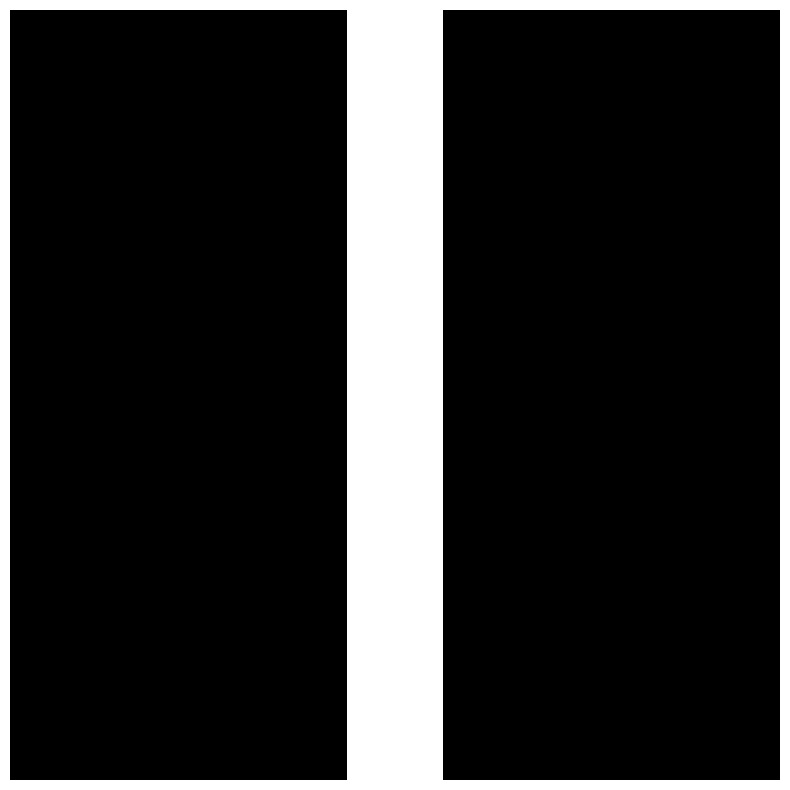

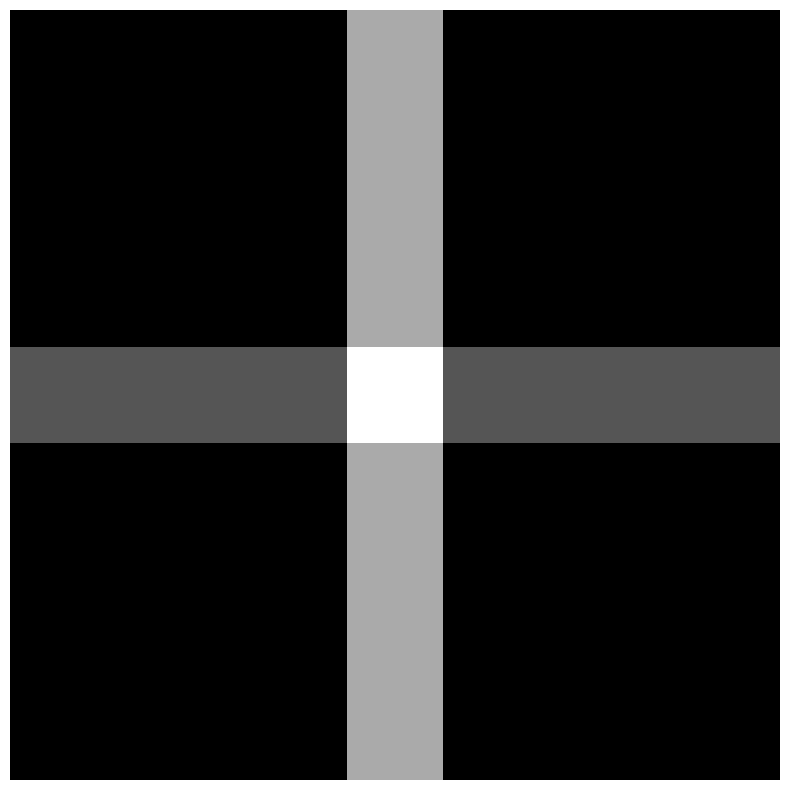

In [2]:
# defining images
F = np.concatenate([np.zeros((56,128)), np.ones((16,128)), np.zeros((56,128))])
G = F.T
H = F + 2*G

for i in [F,G,H]:
    showgrey(i)

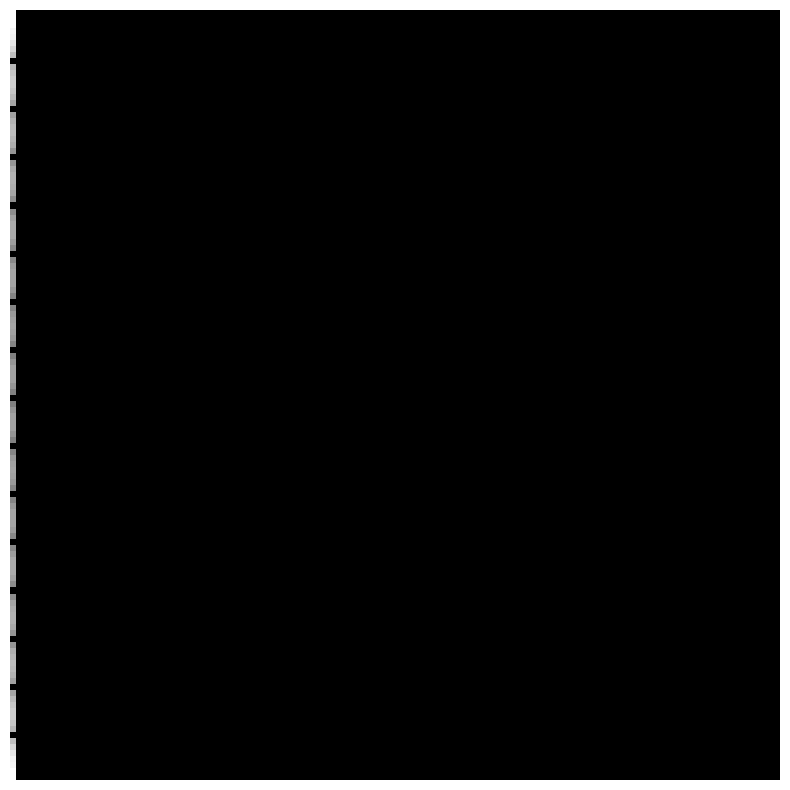

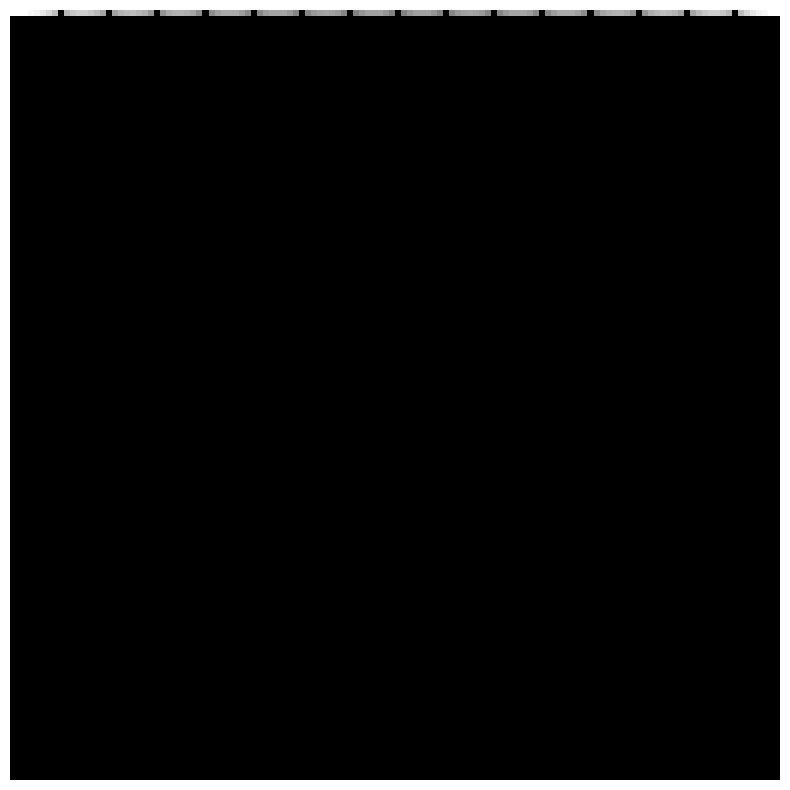

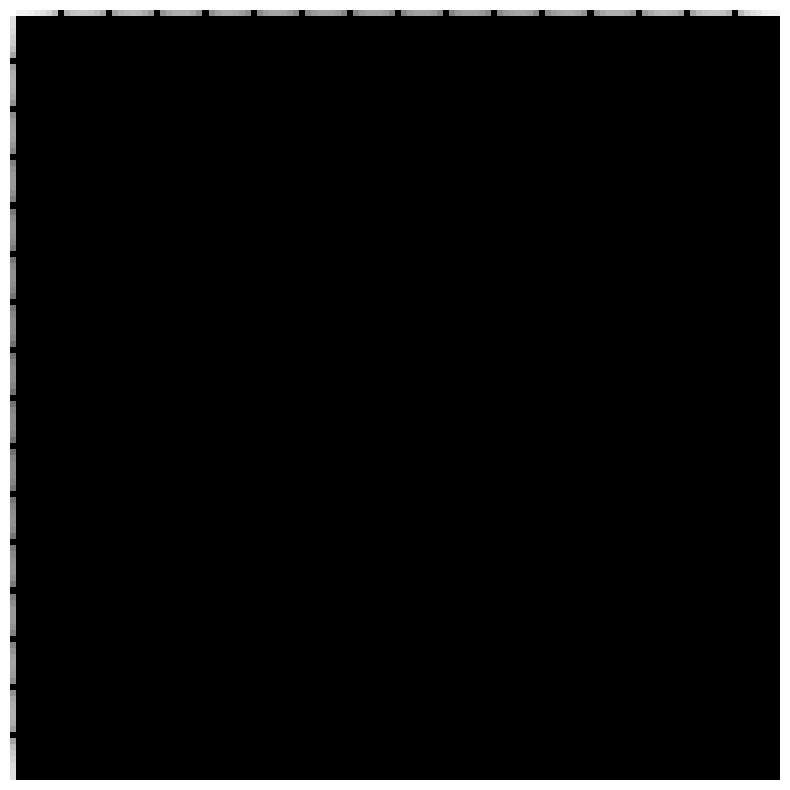

In [3]:
# computing FT
Fhat = fft2(F)
Ghat = fft2(G)
Hhat = fft2(H)

# plotting Fourier spectra
showgrey(np.log(1 + np.abs(Fhat)))
showgrey(np.log(1 + np.abs(Ghat)))
showgrey(np.log(1 + np.abs(Hhat)))

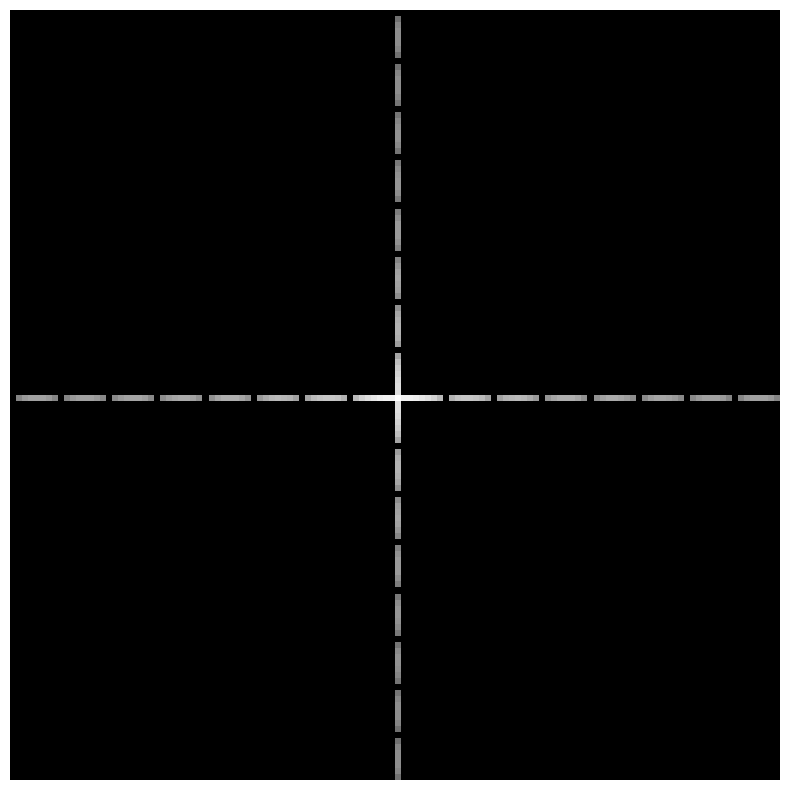

In [4]:
 showgrey(np.log(1 + np.abs(fftshift(Hhat))))

Note : In the last one, we use fftshift to place (0,0) frequency in the center.

- Image 1: The image has a sharp change in intensity along the vertical direction ($x_{1}$-axis), where it transitions from black to white and back to black. The intensity is constant along the horizontal direction except at this transition. Since the horizontal band is uniform along the $x_{2}$-axis, this direction contains only low-frequency components, thus it is on $x_{2}$=0 (0 is not in the center here but on the border). In the y-direction, however, there is a sharp transition (from black to white to black), indicating high-frequency components in the vertical direction.


- Image 2: The image has a sharp intensity change along the horizontal direction ($x_{2}$-axis). The intensity is constant along the vertical direction ($x_{1}$-axis) except at the transition between black and white. This image is the opposite of Image 1 in terms of orientation. The sharp transitions are along the $x_{2}$-axis, indicating high-frequency content in the horizontal direction. There are no transitions along the $x_{2}$-axis, so the vertical direction contains only low frequencies thus it is on $x_{2}$=0 (0 is not in the center here but on the border).


- Image 3: The image has sharp transitions in both the horizontal and vertical directions, resulting in high-frequency components along both axes. This image has sharp transitions in both the $x_{1}$ and $x_{2}$ directions, corresponding to high-frequency components in both directions.

Note: logarithm is applied because of Range Compression concerns (the large values near the "center" would have overshadowed the smaller values at higher frequencies because we observe a $sin_c$)

From the observations, we can conclude that Fourier transform is a linear operator:

$$
F(a f(x) + b g(x)) = a F(f(x)) + b F(g(x))
$$


### Multiplication

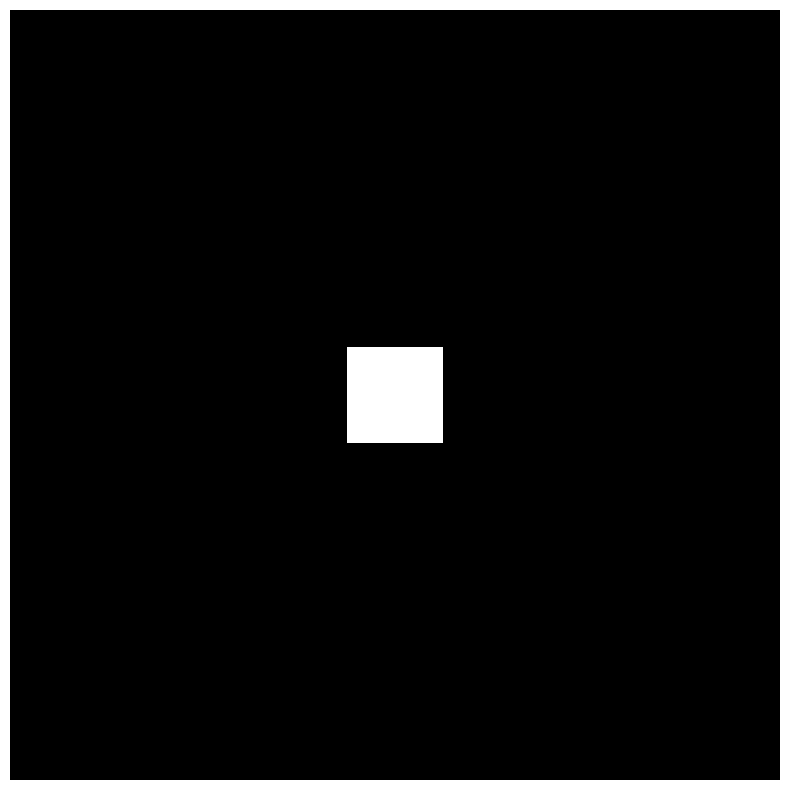

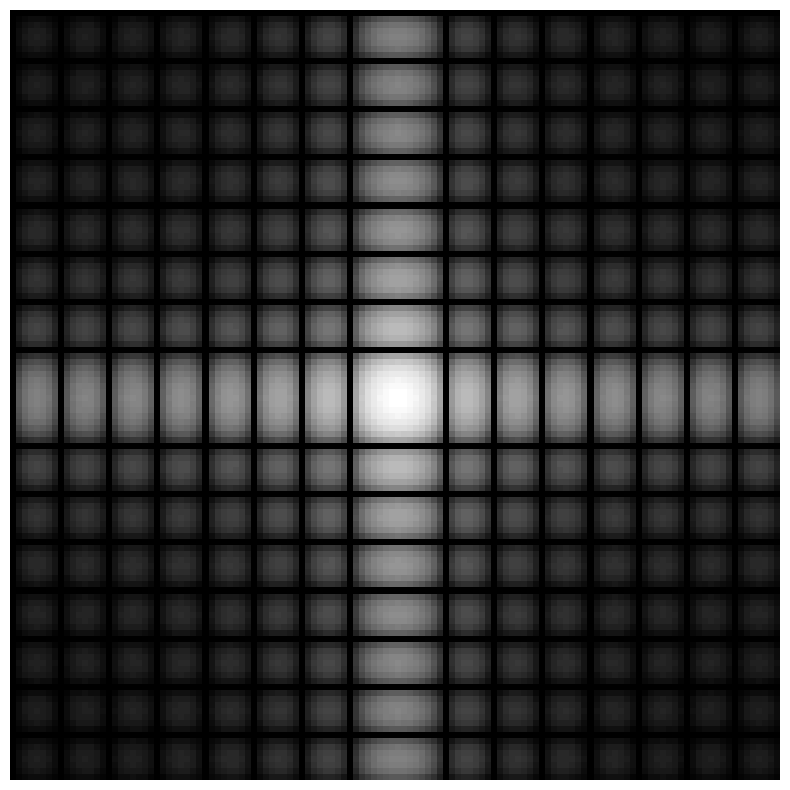

In [12]:
showgrey(F * G)
showfs(fft2(F * G))

- Multiplication in the spatial domain = convolution in the Fourier domain
- Multiplication in the Fourier domain = convolution in the space domain

Therefore, we can also compute the last image by computing the convolution product between the two Fourier transform:

$F(f g)=F(f)*F(g)$

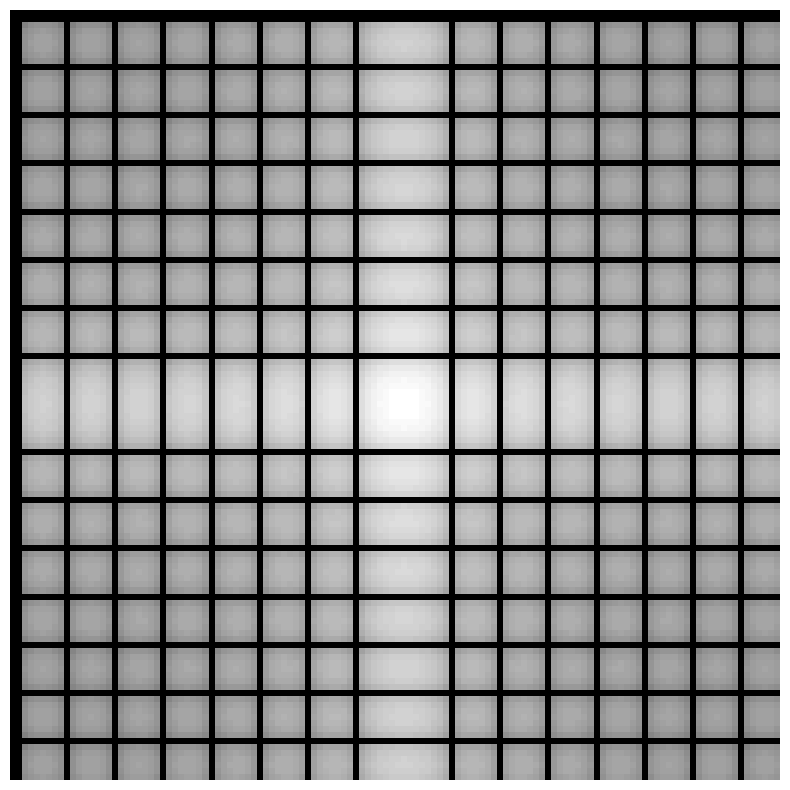

In [8]:
F = np.concatenate([np.zeros((56,128)), np.ones((16,128)), np.zeros((56,128))])
G = F.T

Fhat = fft2(F)
Ghat = fft2(G)

Fhat = fftshift(Fhat)
Ghat = fftshift(Ghat)

convolution_result = convolve2d(Fhat, Ghat, mode='same')
convolution_result = fftshift(convolution_result)
showfs(convolution_result)

### Scaling

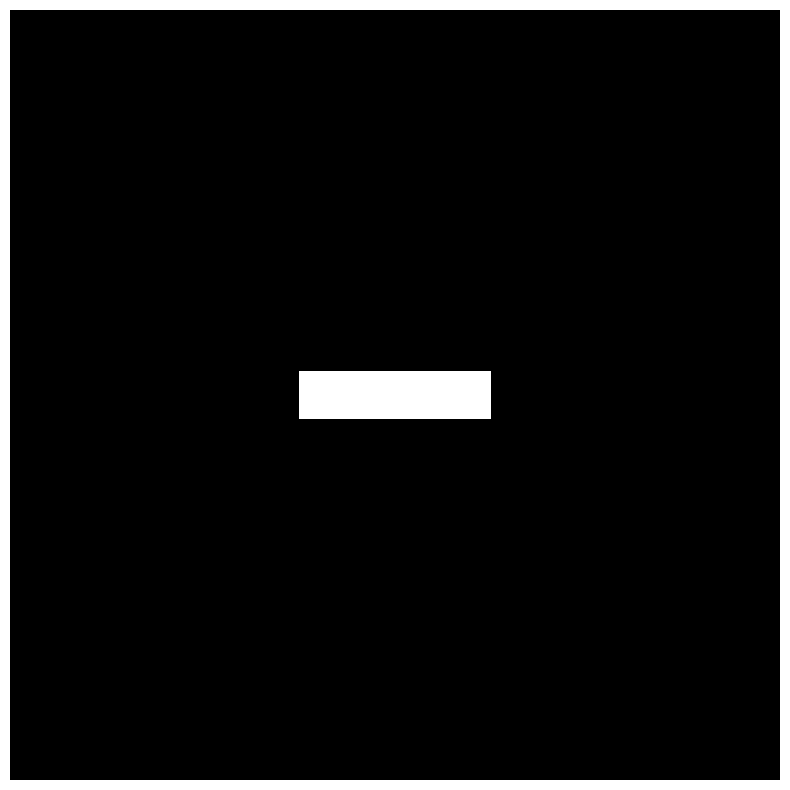

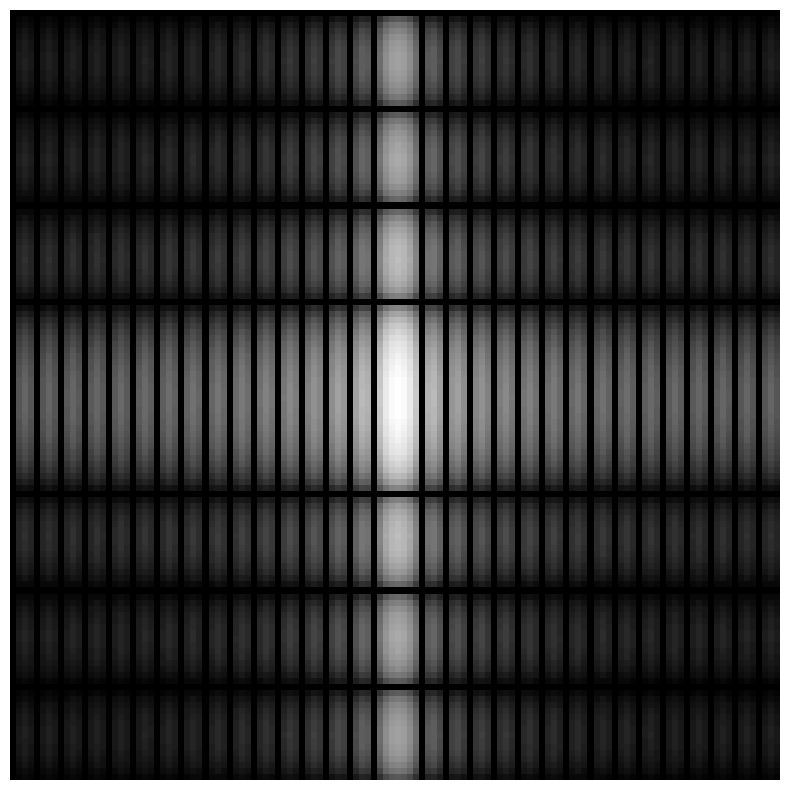

In [14]:
F = np.concatenate([np.zeros((60,128)), np.ones((8,128)), np.zeros((60,128))]) * \
np.concatenate([np.zeros((128,48)), np.ones((128,32)), np.zeros((128,48))], axis=1)
showgrey(F)

Fhat = fft2(F)
showfs(Fhat)

Compared to the first image of the previous exercice, we introduced transitions along the other axis, resulting in $sin_c$ along both axis.

Furthermore, we observe that compression (scale down) in spatial domain is same as expansion (scale up) in Fourier domain (and vice versa).

### Rotation

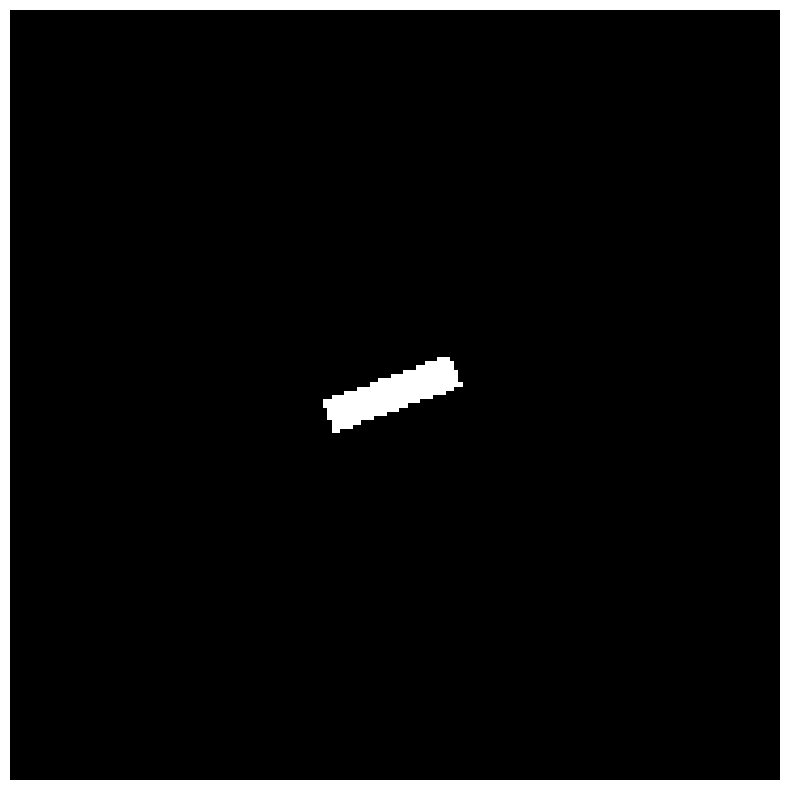

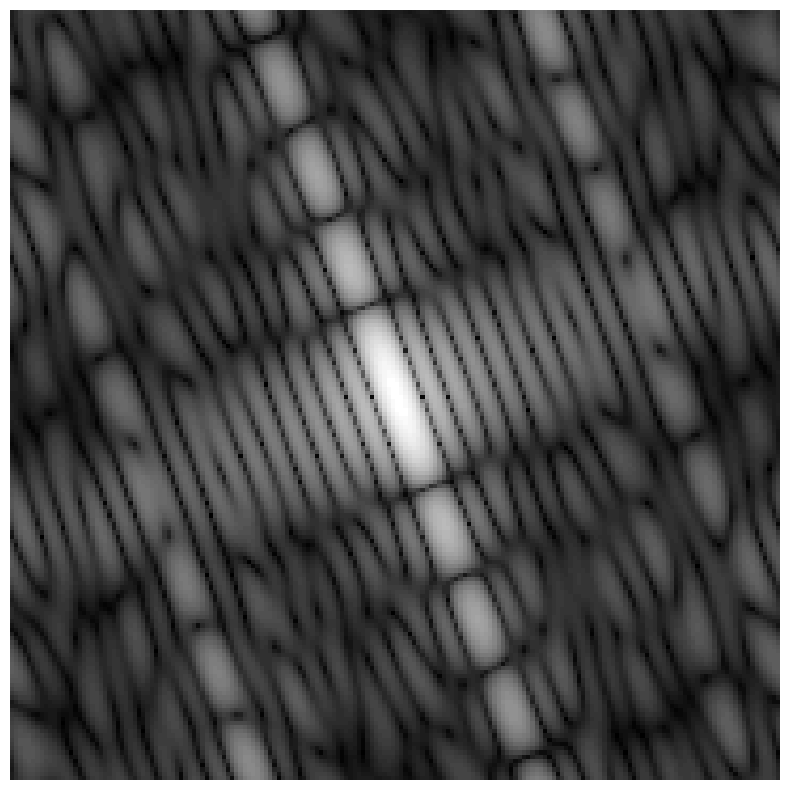

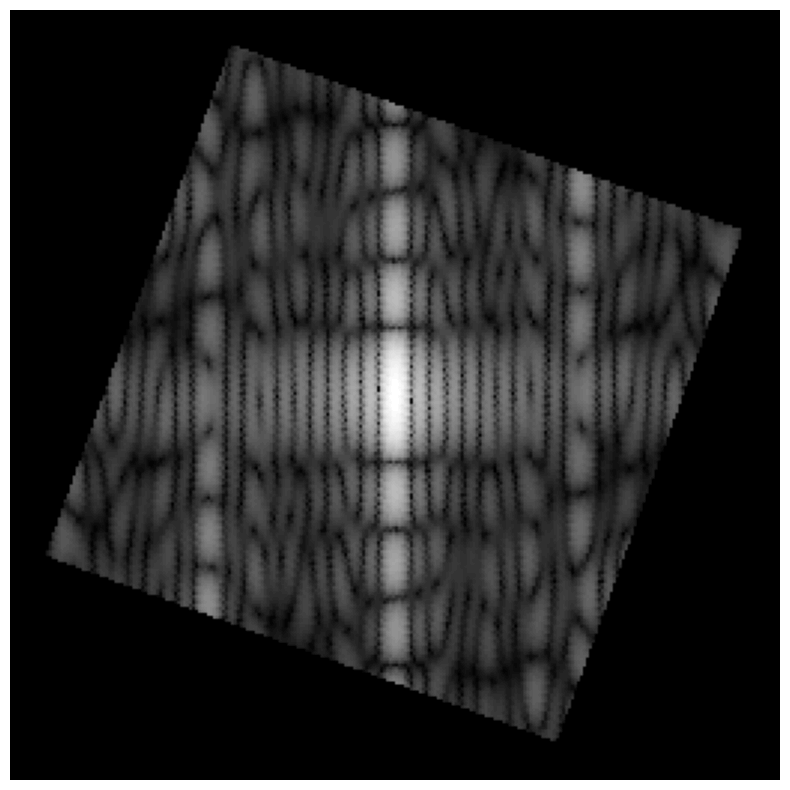

In [15]:
alpha = 20
G = rot(F, alpha)
showgrey(G)

Ghat = fft2(G)
showfs(Ghat)

Hhat = rot(fftshift(Ghat),-alpha)
showgrey(np.log(1 + abs(Hhat)))

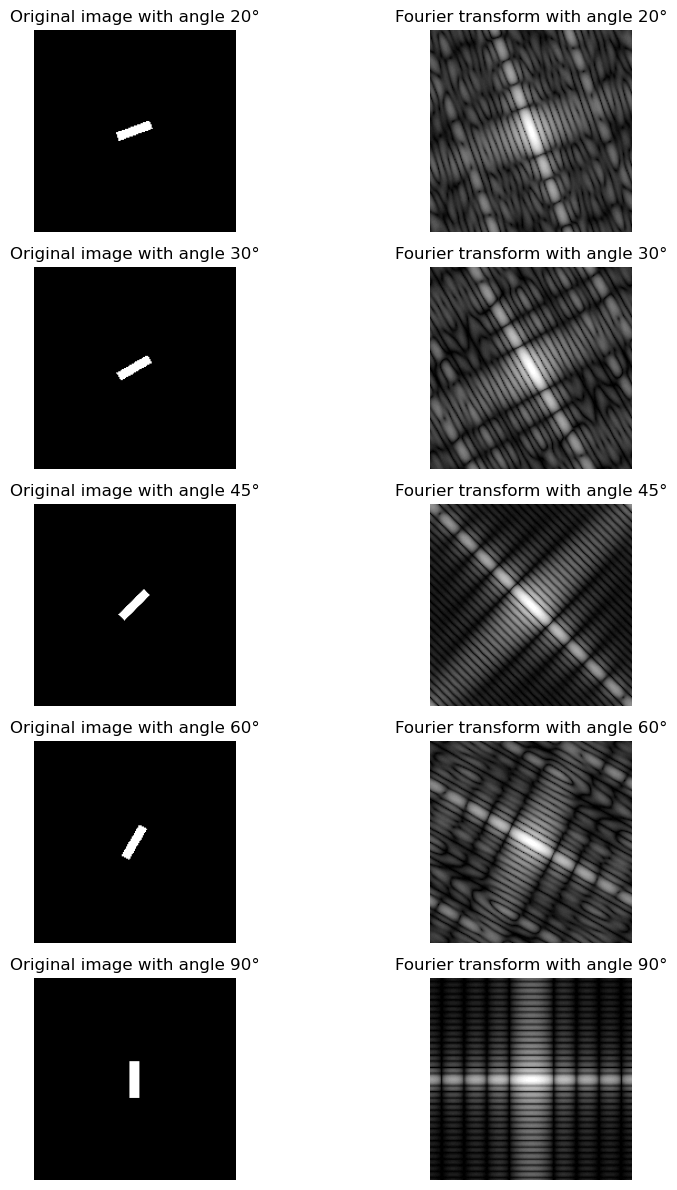

In [26]:
alpha = [20, 30, 45, 60, 90]

fig = plt.figure(figsize=(10, 12))

for i in range(5):
    for j in range(2):
        idx = i * 2 + j
        a = alpha[i]
        G = rot(F, a)
        Ghat = fft2(G)
        
        ax = fig.add_subplot(5, 2, idx + 1)
        
        if j == 0:
            showgrey(G, display = False)
            ax.set_title('Original image with angle {}°'.format(a))
        else:
            showfs(Ghat, display = False)
            ax.set_title('Fourier transform with angle {}°'.format(a))
        
        ax.axis('off')
        
plt.tight_layout()
plt.show()

We observe that a rotation of the image in the spatial domain results in a rotation of the frequency components by the same angle. The magnitude of frequencies are not affected by the rotation. The few differences we can observe are only due to the resolution (not high enough to represent the rotation properly).

### Information in Fourier phase and magnitude

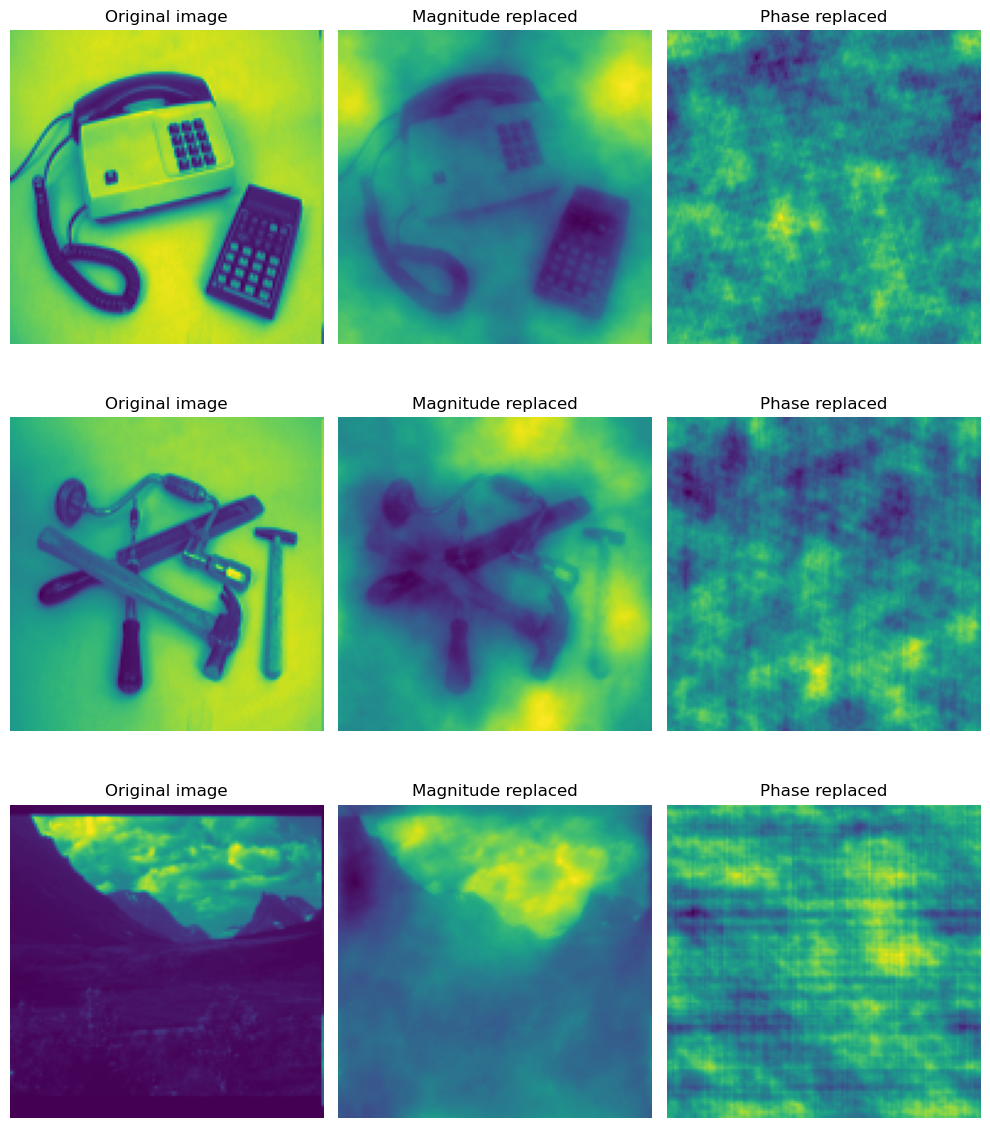

In [39]:
img_1 = np.load("Images-npy/phonecalc128.npy")
img_2 = np.load("Images-npy/few128.npy")
img_3 = np.load("Images-npy/nallo128.npy")

img = [img_1, img_2, img_3]
a = 1e-3

fig = plt.figure(figsize=(10, 12))

for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        ax = fig.add_subplot(3, 3, idx + 1)

        if j == 0:
            ax.imshow(img[i])
            ax.set_title('Original image')
        elif j == 1:
            processed_img = pow2image(img[i], a)
            ax.imshow(processed_img)
            ax.set_title('Magnitude replaced')
        else:
            processed_img = randphaseimage(img[i])
            ax.imshow(processed_img)
            ax.set_title('Phase replaced')
        
        ax.axis('off')

plt.tight_layout()
plt.show()

We observe that if we keep the same phase and change the magnitude (1st case), we are still able to recognize the image but if we keep the magnitude and change the phase (2nd case), it is not possible anymore.

- Magnitude: Describes the intensity of different frequency components, giving an idea of textures and contrasts. Tells us what grey-levels are on either side of edges.
- Phase: Encodes the spatial structure and location of features, which is necessary for reconstructing a coherent image. Tells us where edges will end up in the image.

## 2) Gaussian convolution implemented via FFT

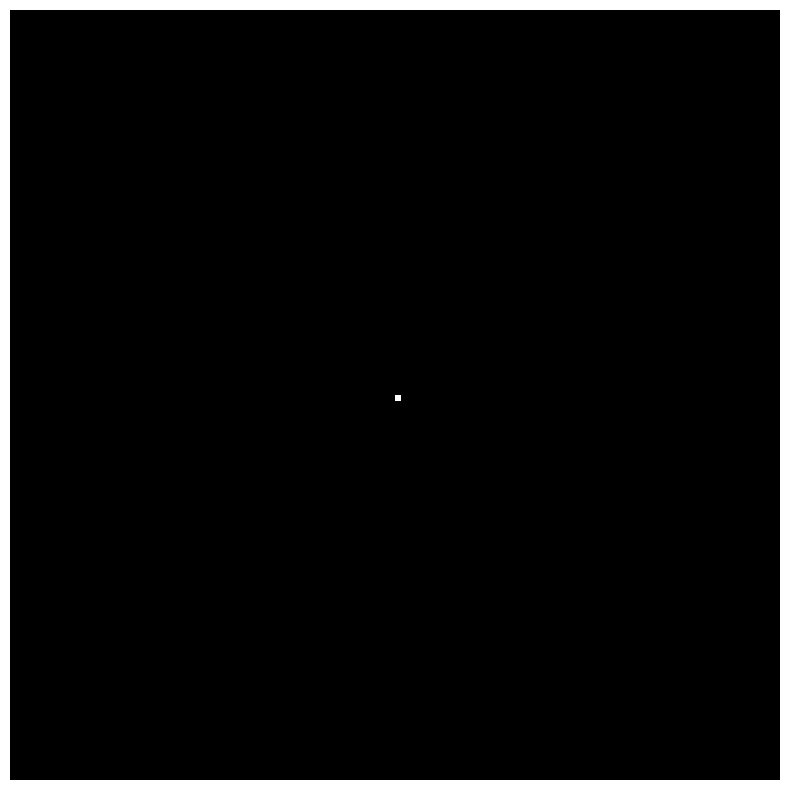

In [2]:
img = deltafcn(128, 128)
showgrey(img)

### Impulse response

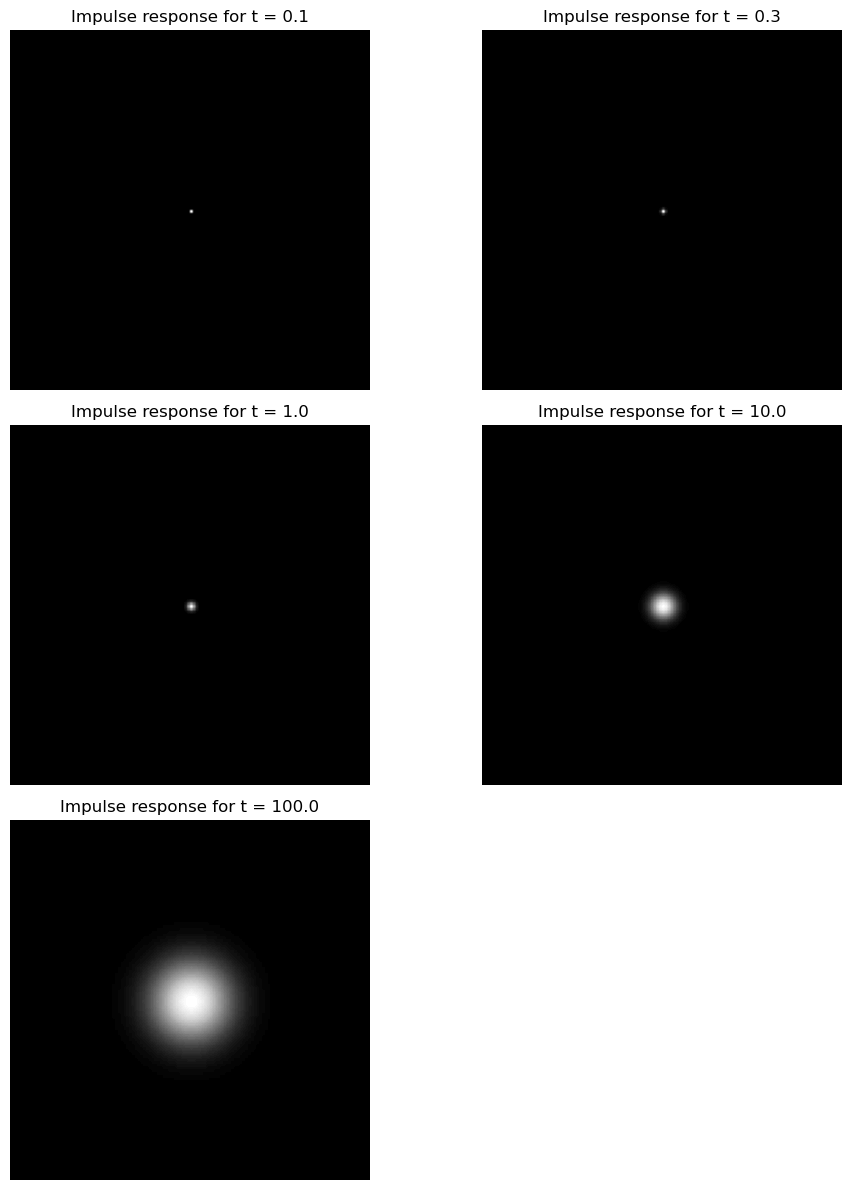

In [14]:
T = [0.1, 0.3, 1.0, 10.0, 100.0]

fig = plt.figure(figsize=(10, 12))

for i in range(3):
    for j in range(2):
        idx = i * 2 + j
        
        if idx<= 4:
            t = T[idx]
    
            ax = fig.add_subplot(3, 2, idx + 1)

            G = gaussfft(deltafcn(128, 128), t)
            showgrey(G, display = False)
            ax.set_title('Impulse response for t = {}'.format(t))
                
            ax.axis('off')
        
plt.tight_layout()
plt.show()

### Covariance matrix

In [13]:
T = [0.1, 0.3, 1.0, 10.0, 100.0]

for t in T:
    print('Covariance matrix for t = {}'.format(t))
    psf = gaussfft(deltafcn(128, 128), t)
    print(variance(psf))

Covariance matrix for t = 0.1
[[1.32967252e-02 1.40998324e-14]
 [1.40998324e-14 1.32967252e-02]]
Covariance matrix for t = 0.3
[[2.81053830e-01 2.40085729e-14]
 [2.40085729e-14 2.81053830e-01]]
Covariance matrix for t = 1.0
[[9.99999789e-01 1.78468351e-14]
 [1.78468351e-14 9.99999789e-01]]
Covariance matrix for t = 10.0
[[ 1.00000000e+01 -1.66811009e-14]
 [-1.66811009e-14  1.00000000e+01]]
Covariance matrix for t = 100.0
[[9.99999993e+01 1.21569421e-14]
 [1.21569421e-14 9.99999993e+01]]


- The diagonal elements describe how the Gaussian is spread out in each of the individual dimensions.
- The off-diagonal elements describe the covariance between the two dimensions. If they are equal to zero, then the two dimensions are independent, and the Gaussian filter is isotropic (having the same spread in all directions). If they are not the filter's shape becomes elliptical, with the orientation of the ellipse determined by the correlation between the $x$ and $y$ axes.

With the discrete case, we are tending toward a slightly anistotropic filter.

In the Fourier domain, a Gaussian's Fourier transform is also a Gaussian, where the spread in the Fourier domain is inversely proportional to the spread in the spatial domain. Specifically, if the Gaussian in the spatial domain has a variance $t$, its Fourier transform will have a variance $\frac{1}{t}$.

- For large $t$, the discrete kernel is a good approximation of the continuous Gaussian, so the covariance matrix of the discrete Gaussian will closely resemble that of the continuous Gaussian. In this case, the discrete Fourier transform will show a narrow spread in frequency space.
- For small $t$, the kernel becomes highly localized in space, and the Fourier transform will be more spread out. However, due to the discrete sampling, this spread may not fully match the ideal continuous Gaussian's Fourier transform, particularly if aliasing occurs.

### Convolution with Gaussian functions for different variances

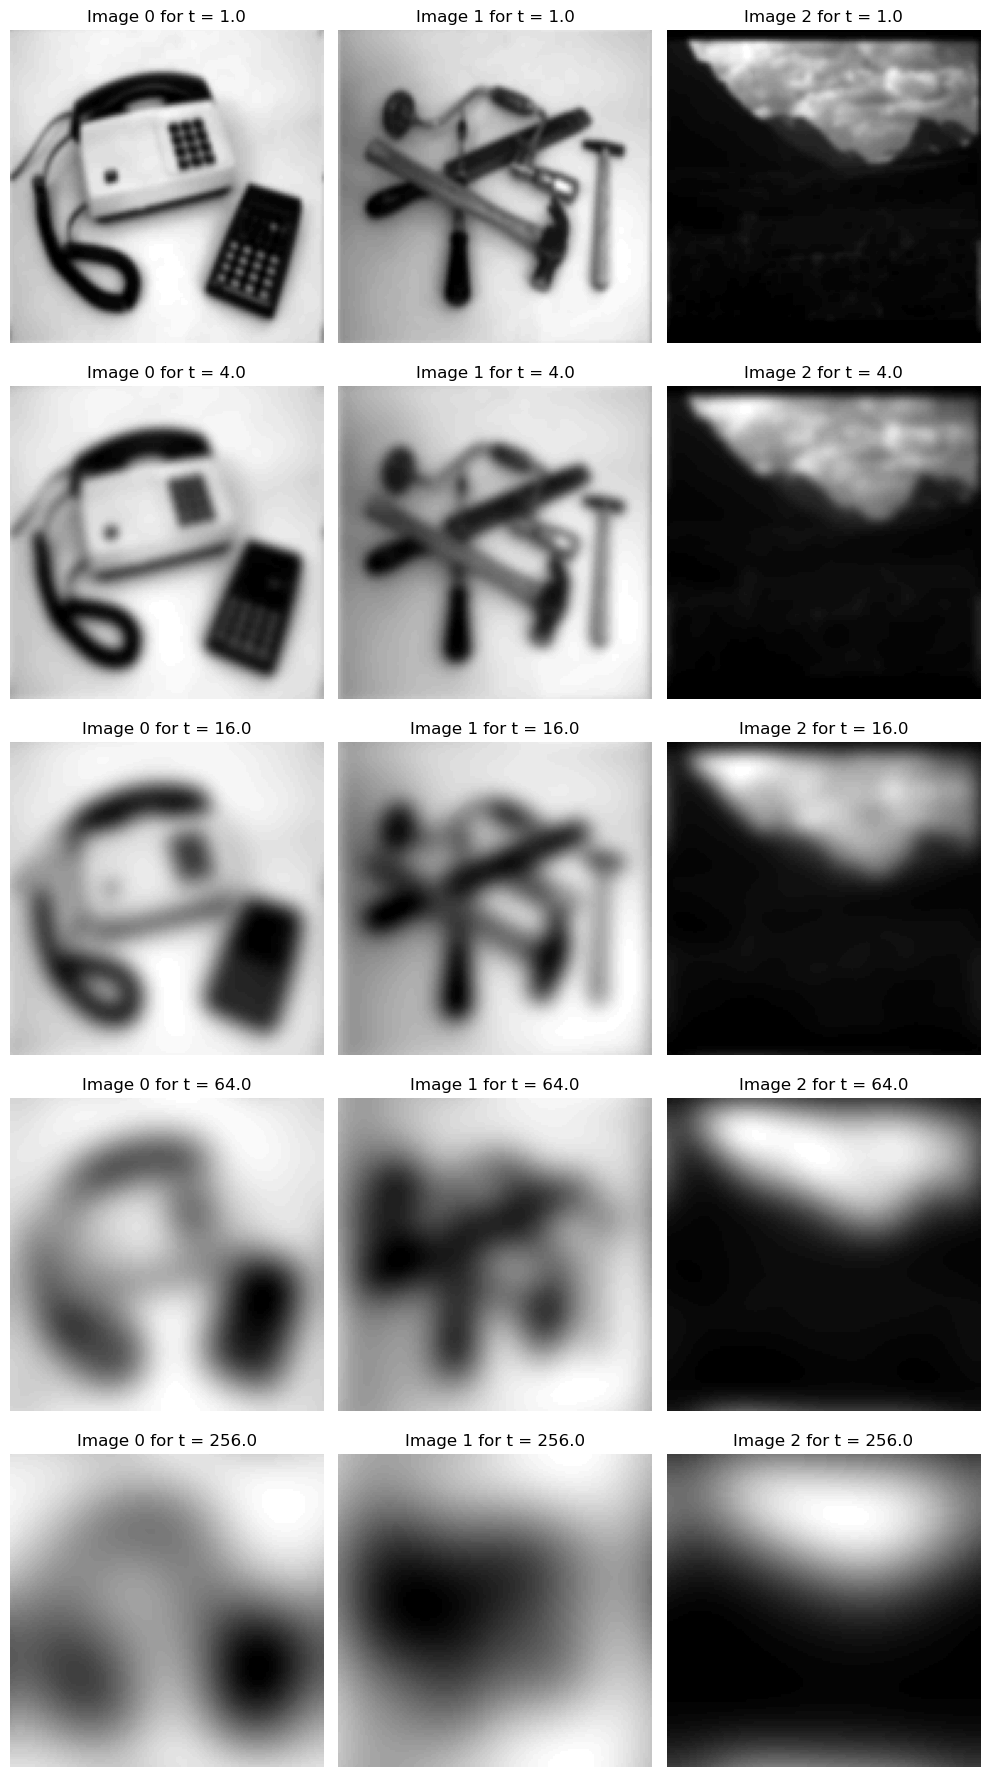

In [5]:
img_1 = np.load("Images-npy/phonecalc128.npy")
img_2 = np.load("Images-npy/few128.npy")
img_3 = np.load("Images-npy/nallo128.npy")

img = [img_1, img_2, img_3]

T = [1.0, 4.0, 16.0, 64.0, 256.0]

fig = plt.figure(figsize=(10, 18))

for i in range(5):
    for j in range(3):
        idx = i * 3 + j
        
        t = T[i]
    
        ax = fig.add_subplot(5, 3, idx + 1)

        
        G = gaussfft(img[j], t)
        showgrey(G, display = False)
        ax.set_title('Image {} for t = {}'.format(j,t))
            
        ax.axis('off')
        
plt.tight_layout()
plt.show()

As the variance $t$ increases, we observe a progressive loss of high-frequency details, resulting in:
- Less detail and texture, especially in fine and mid-level structures.
- Smoother edges with less sharpness.
- Loss of overall structure as $t$ becomes very large, eventually leading to an almost uniform image with faint large-scale gradients.

## 3) Smoothing

### 1 - Smoothing of noisy data

Original image:


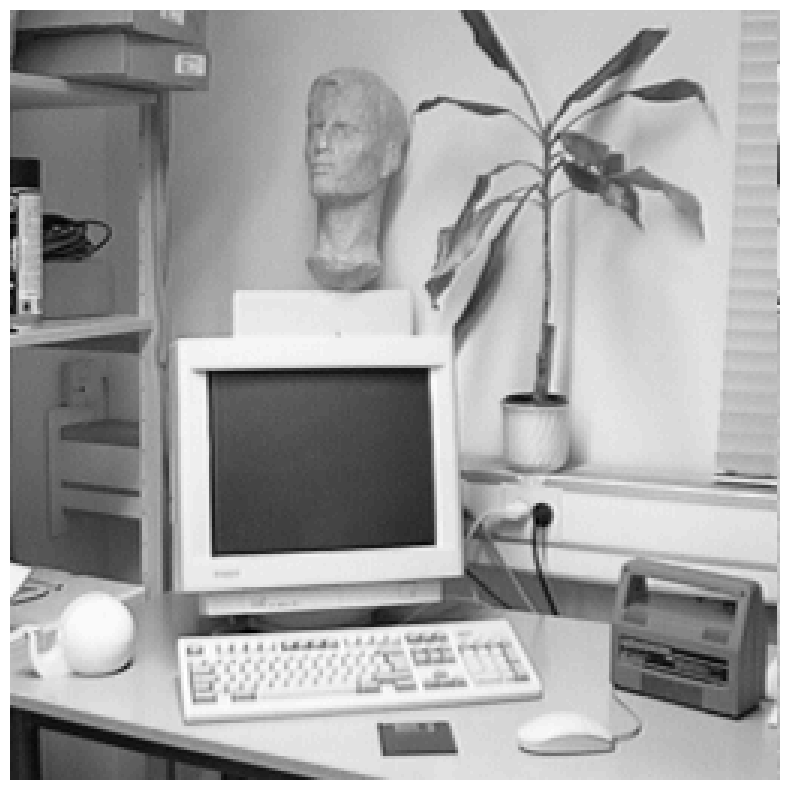

Gaussian noise:


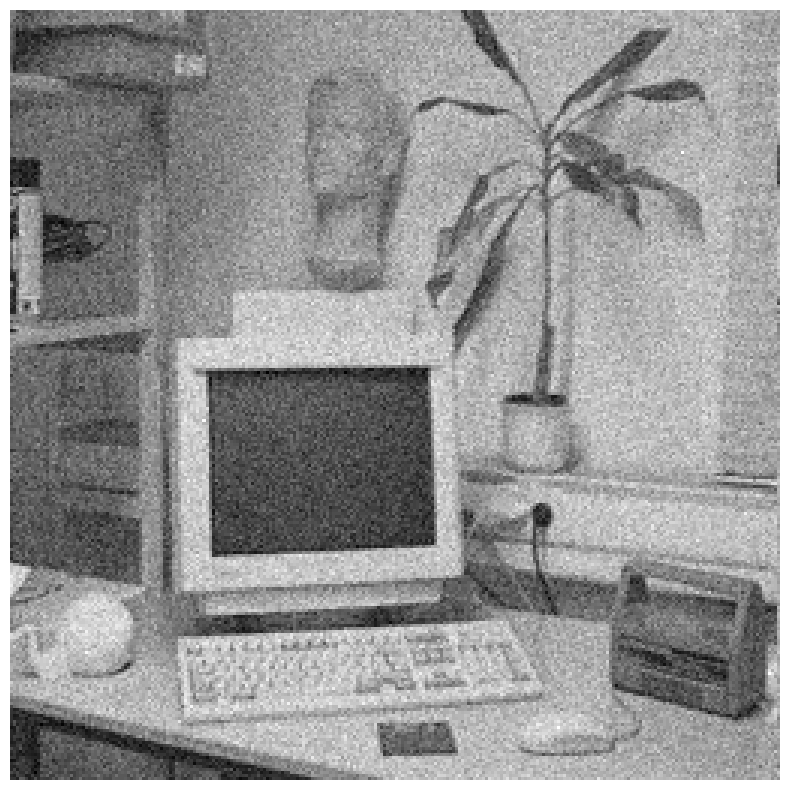

SAP noise:


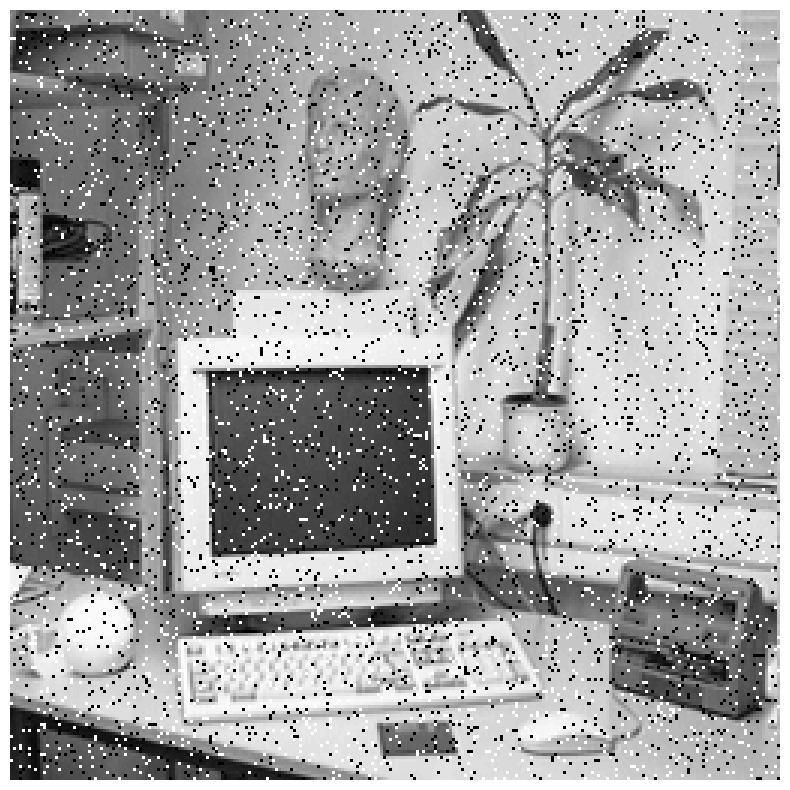

In [7]:
office = np.load("Images-npy/office256.npy")

print('Original image:')
showgrey(office)

add = gaussnoise(office, 16)
sap = sapnoise(office, 0.1, 255)

print('Gaussian noise:')
showgrey(add)

print('SAP noise:')
showgrey(sap)

- Gaussian Noise: Each pixel in the image has a certain intensity value. When Gaussian noise is added, each pixel's intensity is adjusted by a small amount of noise according to a Gaussian distribution. Continuous, grainy appearance, affects the whole image with slight variations.
- SAP Noise: Some pixels in the image are randomly set to either the maximum (white, "salt") or minimum (black, "pepper") intensity value. Discrete black-and-white spots, affects only certain pixels.

### Comparison of different filters:

Gaussian filter

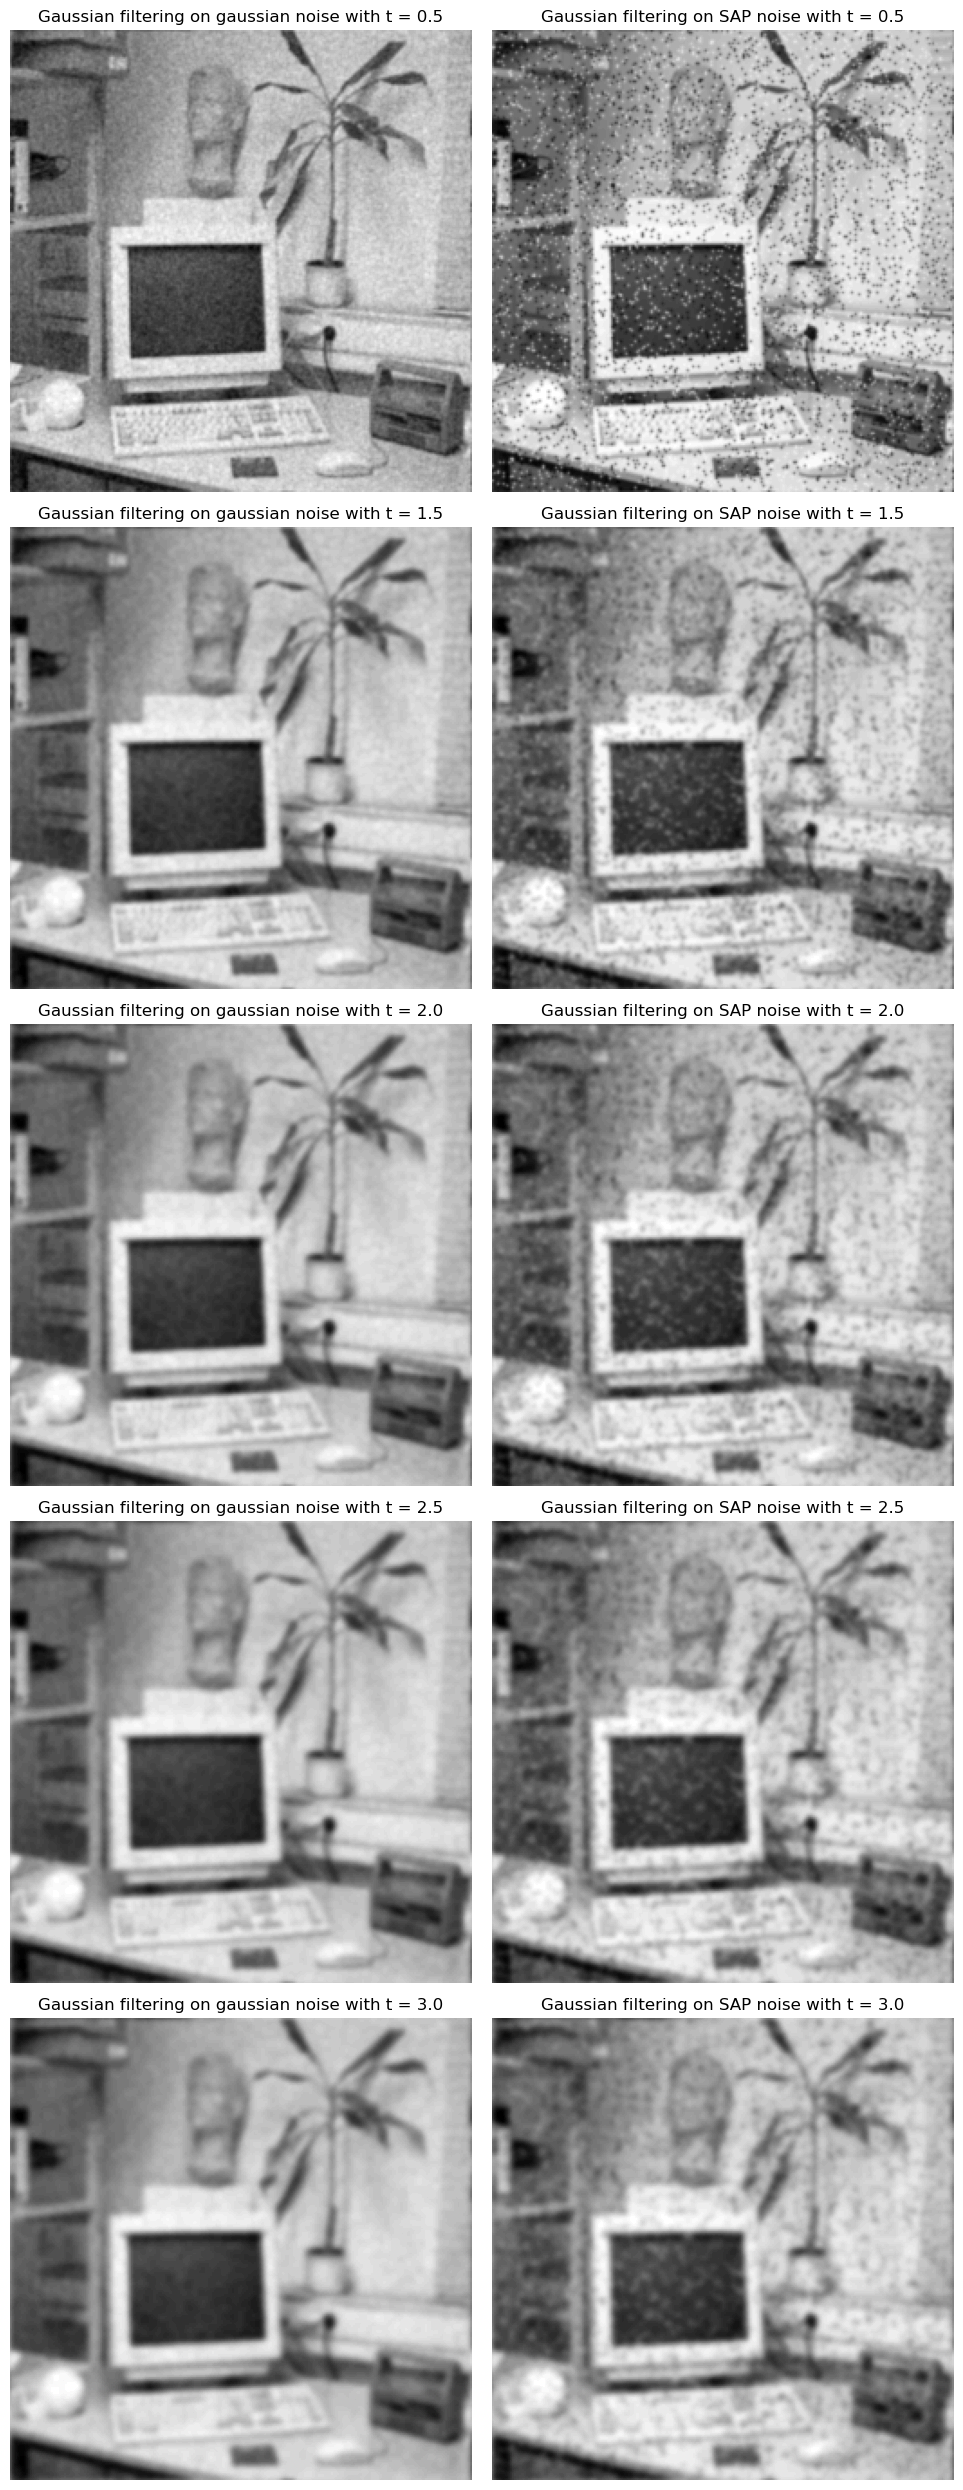

In [8]:
T = [0.5, 1.5, 2.0, 2.5, 3.0]

fig = plt.figure(figsize=(10, 25))

for i in range(5):
    for j in range(2):
        idx = i * 2 + j
        
        t = T[i]
    
        ax = fig.add_subplot(5, 2, idx + 1)

        if j == 0:
            G = gaussfft(add, t)
            showgrey(G, display = False)
            ax.set_title('Gaussian filtering on gaussian noise with t = {}'.format(t))

        else:
            G = gaussfft(sap, t)
            showgrey(G, display = False)
            ax.set_title('Gaussian filtering on SAP noise with t = {}'.format(t))
                
        ax.axis('off')
        
plt.tight_layout()
plt.show()

Positive Effects:

- Noise Reduction: Gaussian smoothing reduces high-frequency noise effectively, which is especially useful for images with Gaussian-like noise.
- Edge Preservation (to some extent): The Gaussian kernel preserves larger structures and edges better than a simple averaging filter, as it applies a smooth falloff in pixel weights based on distance.
  
Negative Effects:

- Loss of Detail: As $t$ increases, fine details (such as textures and small edges) become blurred, leading to a softer, less defined image.
- Edge Blur: Although Gaussian smoothing is gentler on edges than uniform filters, it still causes edges to blur and lose sharpness with larger $t$ values, which can create a "halo" effect around edges.

Observed Effects:

- At low $t$, the image appears slightly softened, with subtle noise reduction but maintained details.
At higher $t$, textures and details fade, with visible blurring around edges and a progressively smoother appearance. This effect is known as Gaussian blur.

Median filtering

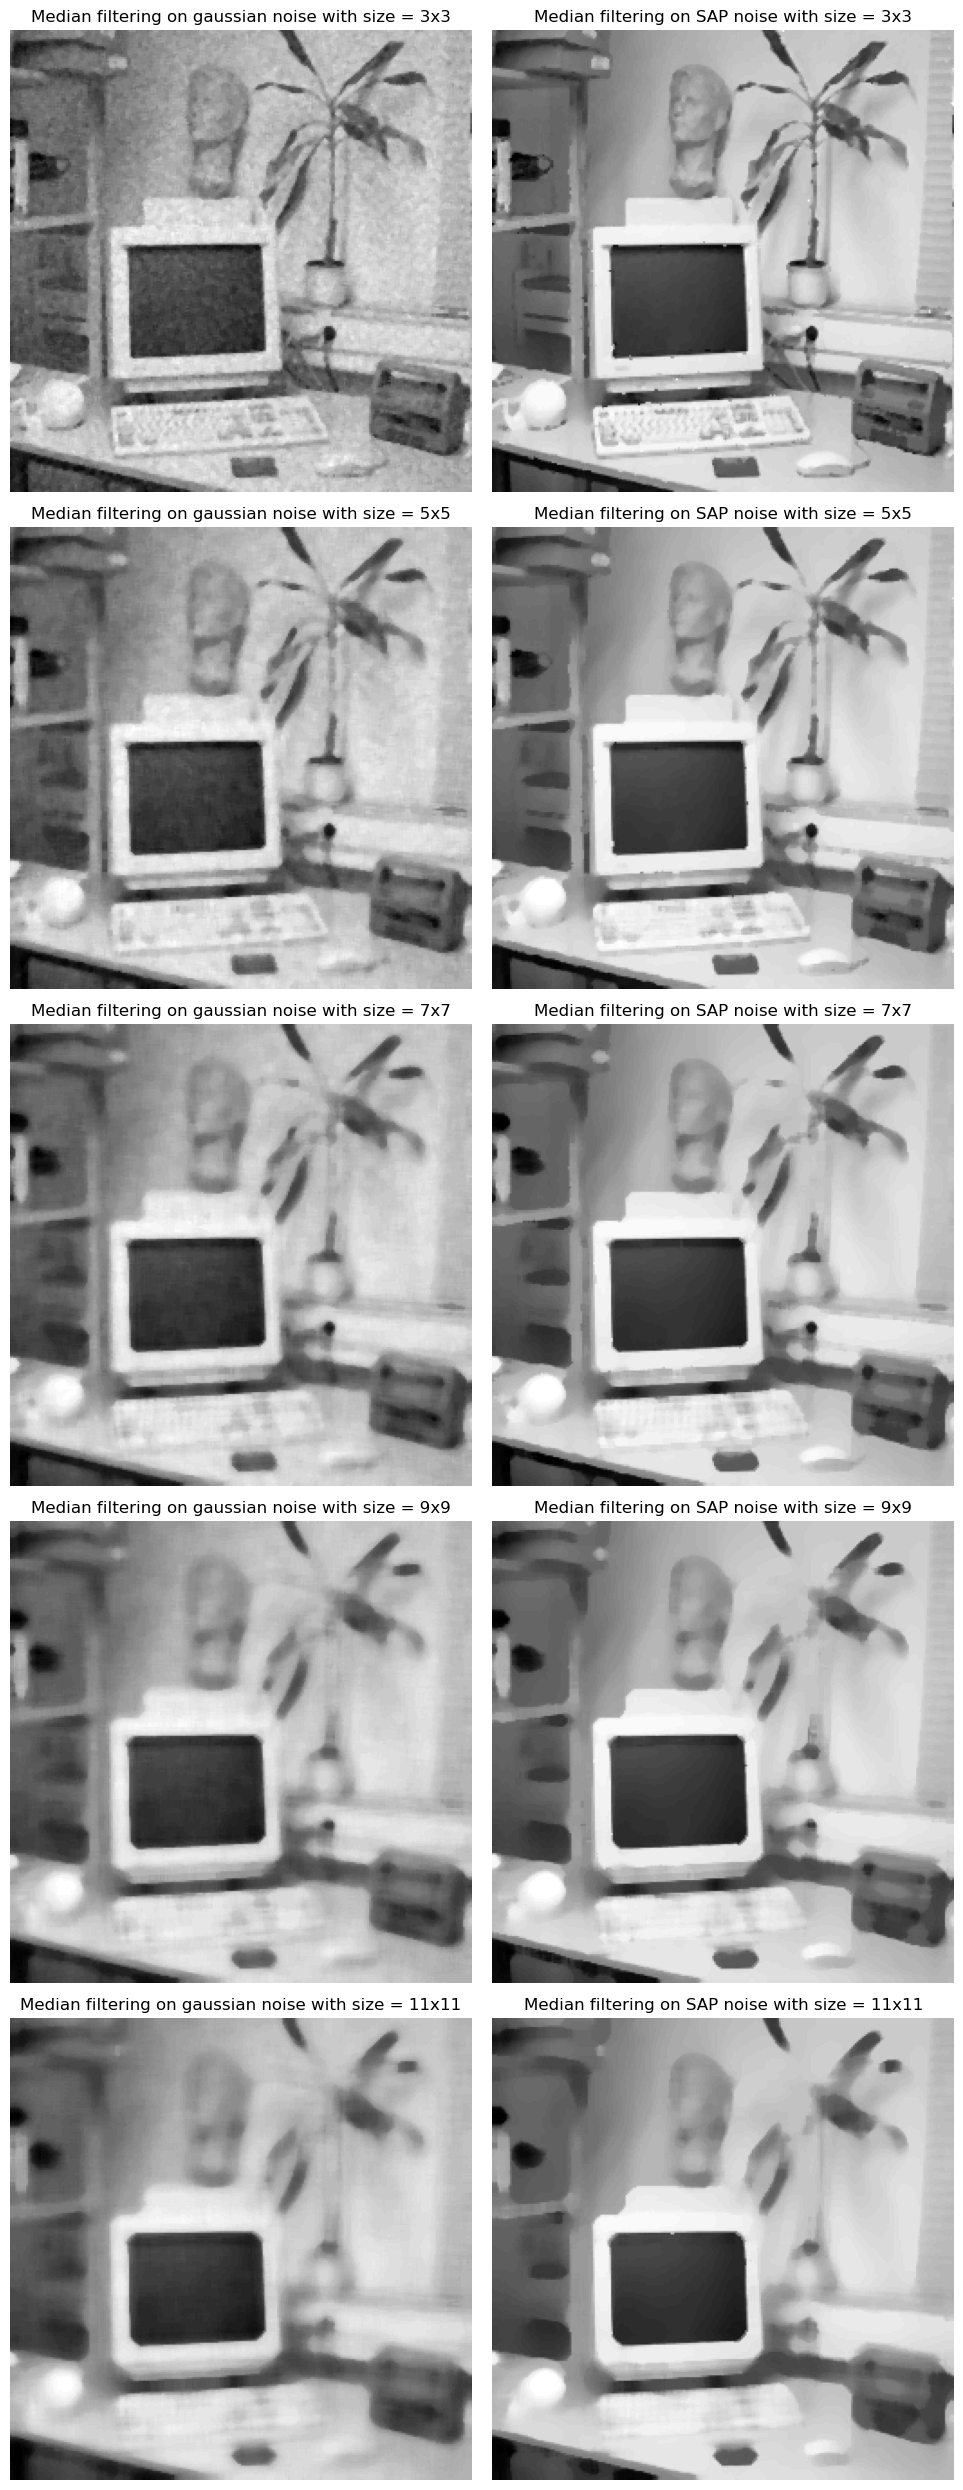

In [36]:
W = [3, 5, 7, 9, 11]

fig = plt.figure(figsize=(10, 25))

for i in range(5):
    for j in range(2):
        idx = i * 2 + j
        
        w = W[i]
    
        ax = fig.add_subplot(5, 2, idx + 1)

        if j == 0:
            G = medfilt(add, w)
            showgrey(G, display = False)
            ax.set_title('Median filtering on gaussian noise with size = {}x{}'.format(w,w))

        else:
            G = medfilt(sap, w)
            showgrey(G, display = False)
            ax.set_title('Median filtering on SAP noise with size = {}x{}'.format(w,w))
                
        ax.axis('off')
        
plt.tight_layout()
plt.show()

Positive Effects:

- Effective Salt-and-Pepper Noise Removal: Median filtering is highly effective for removing isolated noise points (salt-and-pepper noise) without affecting other areas as much as a Gaussian or mean filter.
- Edge Preservation: Unlike Gaussian smoothing, median filtering preserves edges relatively well because it replaces pixel values with an actual neighboring value, not an average.
  
Negative Effects:

- Detail Loss: Median filtering can remove small details and textures, particularly at larger kernel sizes, which can make the image look "blocky" or patchy.
- Reduced Effectiveness on Gaussian Noise: Median filtering is not as effective at reducing Gaussian or other continuous noise, as it’s mainly optimized for impulse noise.
  
Observed Effects:

- With a small kernel size, minor salt-and-pepper noise is removed while maintaining most image details.
- With larger kernels, the image appears “blocky” or “patchy,” and fine textures are lost, leading to a smoother but less natural appearance. This is often called the blocky effect of median filtering.

Ideal low-pass filtering

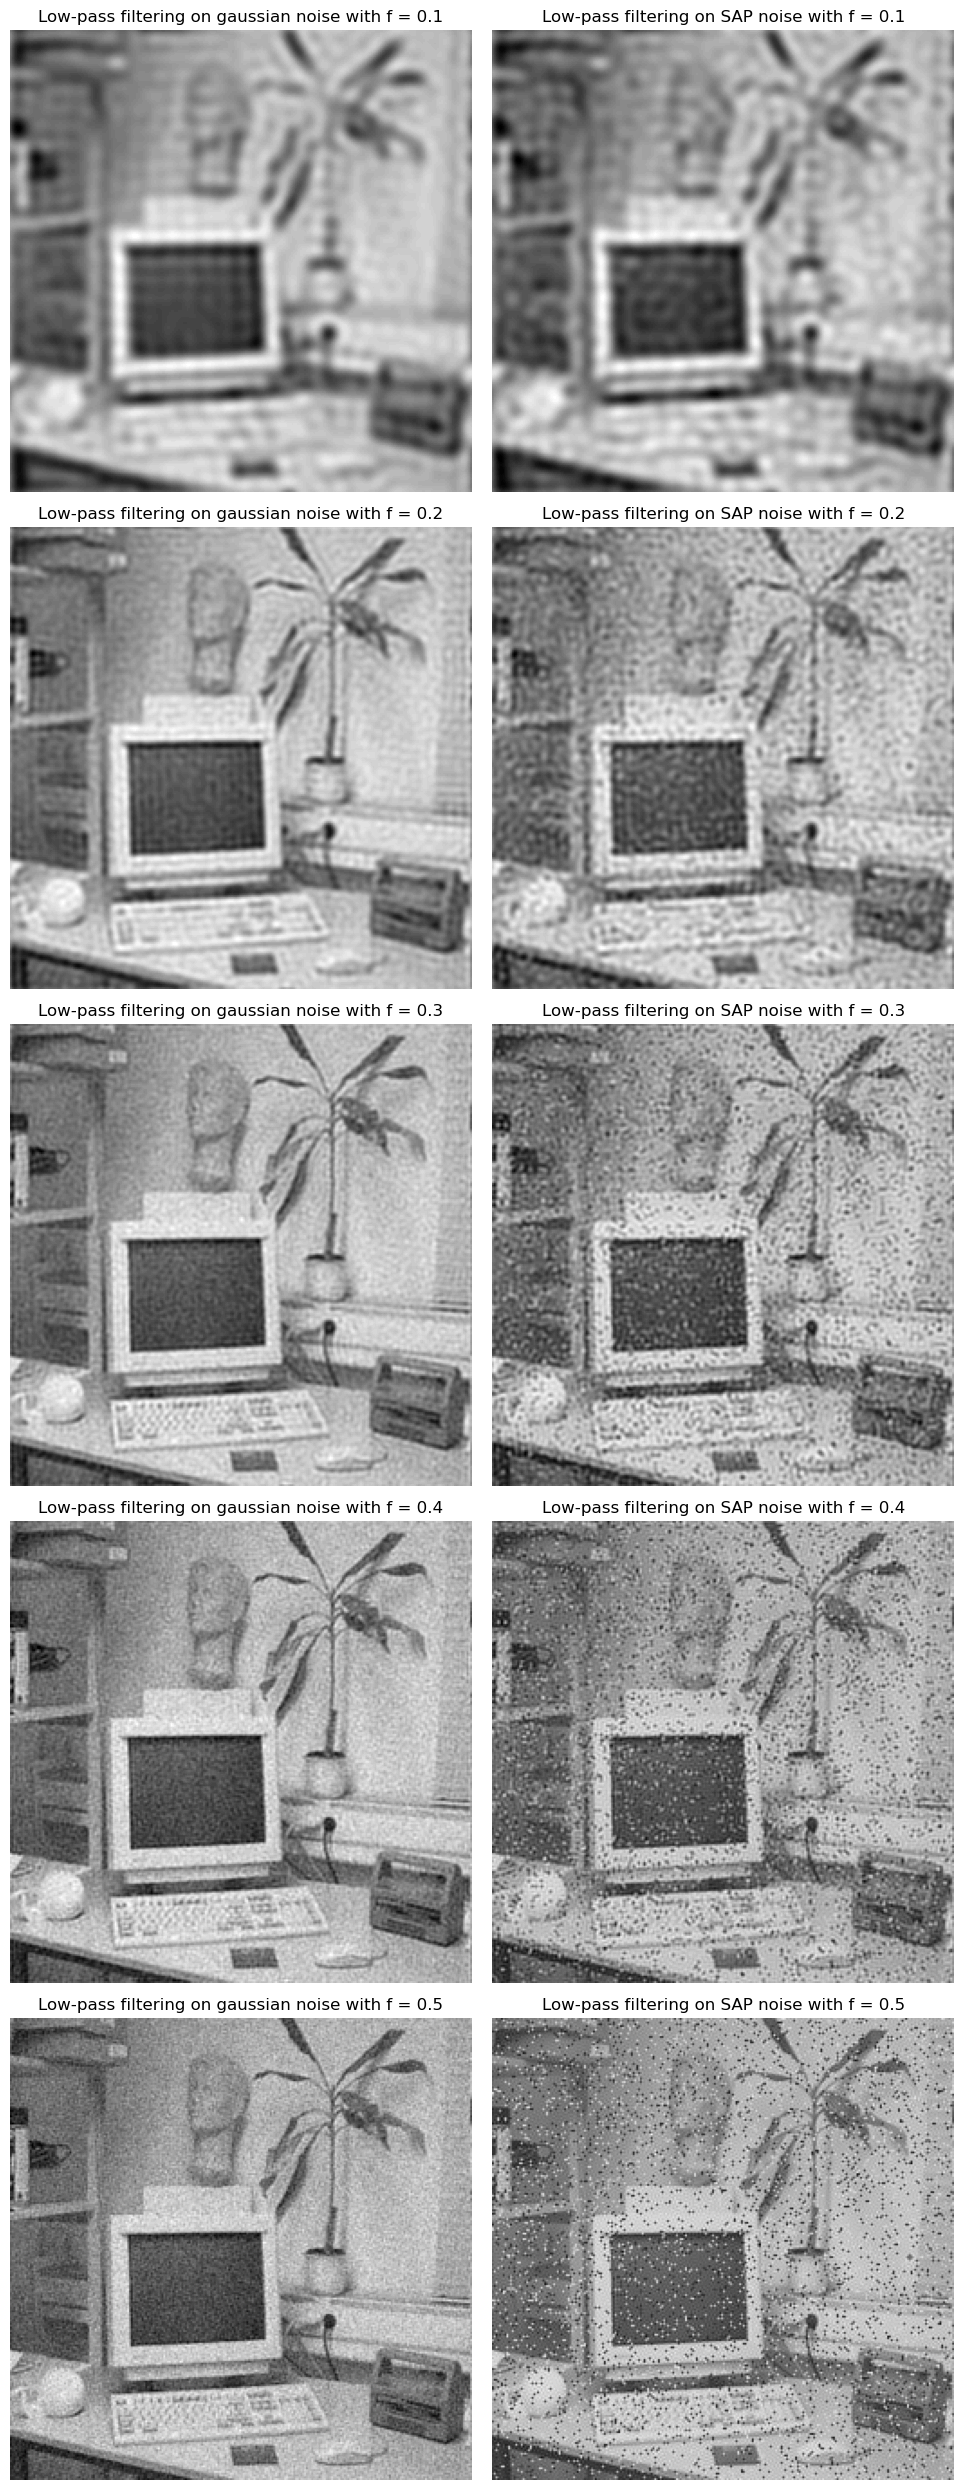

In [37]:
F = [0.1, 0.2, 0.3, 0.4, 0.5]

fig = plt.figure(figsize=(10, 25))

for i in range(5):
    for j in range(2):
        idx = i * 2 + j
        
        f = F[i]
    
        ax = fig.add_subplot(5, 2, idx + 1)

        if j == 0:
            G = ideal(add, f)
            showgrey(G, display = False)
            ax.set_title('Low-pass filtering on gaussian noise with f = {}'.format(f))

        else:
            G = ideal(sap, f)
            showgrey(G, display = False)
            ax.set_title('Low-pass filtering on SAP noise with f = {}'.format(f))
                
        ax.axis('off')
        
plt.tight_layout()
plt.show()

Positive Effects:

- Strong Smoothing: Ideal low-pass filtering can completely eliminate high-frequency noise and fine details, giving a very smooth appearance.
- Consistent Blur: It applies uniform smoothing, making the image look evenly blurred without any patchiness or blocky effects.
  
Negative Effects:

- Sharp Edges and Artifacts: Ideal low-pass filtering can introduce blocky effects and grid-like patterns because of extremely low cut-off frequencies (smooth out large parts of the image).
- Extreme Detail Loss: Fine details, edges, and textures are entirely removed if the cutoff is too low, leading to an image that may lose its original structure or recognizable features.
  
Observed Effects:

- With a high cutoff frequency, the image retains some details but has reduced high-frequency noise.
- With a lower cutoff, the image appears overly smooth, with severe blurring, and ringing artifacts become visible around edges due to the abrupt frequency cutoff. This is a characteristic of ideal low-pass filtering artifacts and is most noticeable near sharp transitions.

Conclusions from the comparison:

- Gaussian Smoothing: Best for Gaussian-like noise reduction, providing a natural blur that keeps edges moderately intact. As blur strength increases, edges and fine details soften, making it suitable where noise reduction is more important than detail preservation.

- Median Filtering: Ideal for removing salt-and-pepper noise without excessive blurring, preserving edges well. It’s suitable for images with isolated noise points but may look blocky at large kernel sizes.

- Ideal Low-Pass Filtering: Strong noise reduction by eliminating high frequencies, but it causes detail loss and blockiness. It suits applications where eliminating fine noise matters more than preserving image detail.

### 2 - Smoothing and subsampling

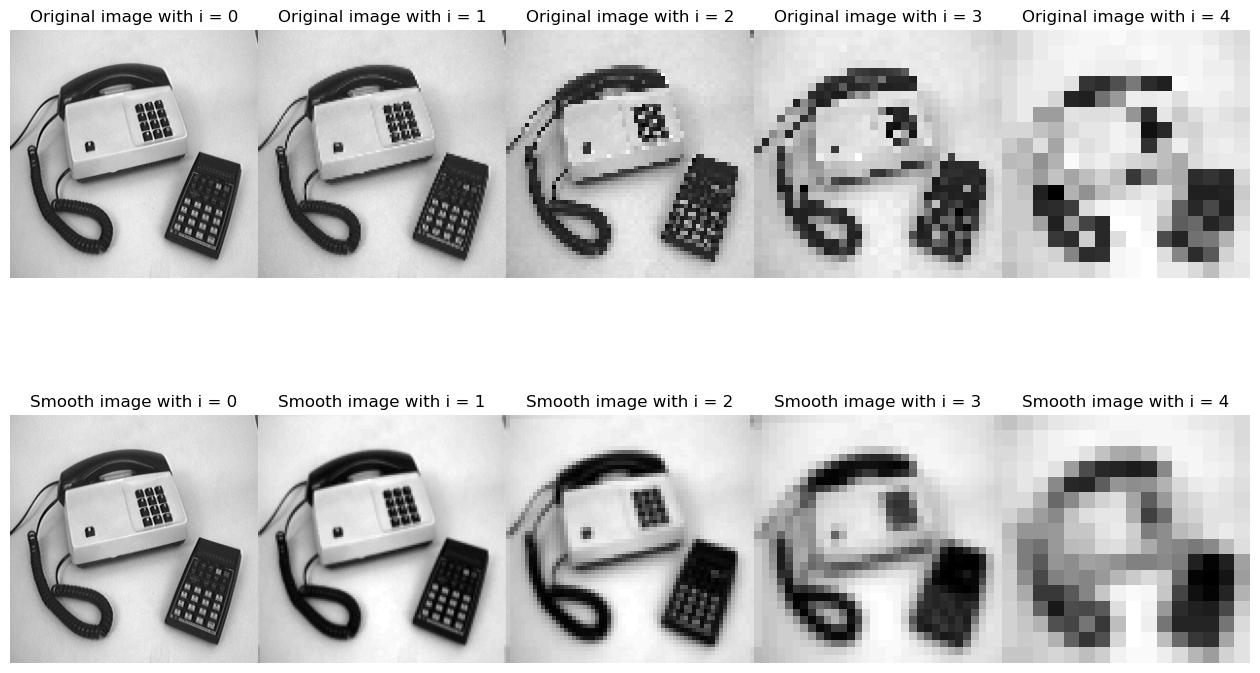

In [10]:
img = np.load("Images-npy/phonecalc256.npy")
smoothimg = img
N = 5
f = plt.figure()
f.subplots_adjust(wspace=0, hspace=0)

for i in range(N):
    if i > 0:  # Generate subsampled versions
        img = rawsubsample(img)
        smoothimg = gaussfft(smoothimg, 0.7)
        smoothimg = rawsubsample(smoothimg)
    
    # Original image subplot
    ax1 = f.add_subplot(2, N, i + 1)
    ax1.set_title('Original image with i = {}'.format(i))
    ax1.axis('off')  # Remove axis
    showgrey(img, False)
    
    # Smoothed image subplot
    ax2 = f.add_subplot(2, N, i + N + 1)
    ax2.set_title('Smooth image with i = {}'.format(i))
    ax2.axis('off')  # Remove axis
    showgrey(smoothimg, False)

plt.show()

Observations:

- On the original image, we observe “stair-step” edges and grey-level aberrations.
- On the smooth version, we observe softer edges and consistent grey-levels (low-frequency structure is conserved, still possible to recognize the image).

Conclusions:

Smoothing before subsampling prevents aliasing, which would otherwise manifest as unwanted patterns or artifacts when the image is subsampled. High frequencies are removed, preventing them to fold on lower ones. 

However, a side effect of smoothing before subsampling is the potential loss of sharpness and details. Edges, which are high-frequency components, are often blurred or softened, making the image look overly smoothed.

There is a trade-off regarding how much smoothing to apply before subsampling: insufficient smoothing results in aliasing, while excessive smoothing blurs the image too much.